In [ ]:
# Import necessary libraries
from fastai.text.all import *
from pathlib import Path
from google.colab import drive
import torch.nn.functional as F
from torch import optim


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your text file
file_path = Path('/content/drive/My Drive/shakespeare.txt')

# Read the content of the text file
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# Prepare data for language modeling
df = pd.DataFrame({'text': [text]})
dls = TextDataLoaders.from_df(df, text_col='text', is_lm=True, valid_pct=0.1)

# Show a batch of the data
dls.show_batch()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,text_
0,"xxbos xxup the xxup xxunk \n\n by xxmaj xxunk xxmaj xxunk \n\n xxmaj from fairest xxunk we desire increase , \n xxmaj that xxunk beauty 's rose might never die , \n xxmaj but as the xxunk should by time decease , \n xxmaj his tender heir might bear his memory : \n xxmaj but thou xxunk to thine own bright eyes , \n xxmaj xxunk thy light 's flame with self","xxup the xxup xxunk \n\n by xxmaj xxunk xxmaj xxunk \n\n xxmaj from fairest xxunk we desire increase , \n xxmaj that xxunk beauty 's rose might never die , \n xxmaj but as the xxunk should by time decease , \n xxmaj his tender heir might bear his memory : \n xxmaj but thou xxunk to thine own bright eyes , \n xxmaj xxunk thy light 's flame with self -"
1,"xxunk xxunk \n xxmaj xxunk the xxunk of thy xxunk ? \n xxmaj or who is he so xxunk will be the tomb , \n xxmaj of his self - love to xxunk posterity ? \n xxmaj thou art thy mother 's glass and she in thee \n xxmaj calls back the lovely xxmaj april of her prime , \n xxmaj so thou through windows of thine age shalt see , \n","xxunk \n xxmaj xxunk the xxunk of thy xxunk ? \n xxmaj or who is he so xxunk will be the tomb , \n xxmaj of his self - love to xxunk posterity ? \n xxmaj thou art thy mother 's glass and she in thee \n xxmaj calls back the lovely xxmaj april of her prime , \n xxmaj so thou through windows of thine age shalt see , \n xxmaj"
2,"their show , their substance still lives sweet . \n▁\n xxmaj then let not winter 's xxunk hand xxunk , \n xxmaj in thee thy summer ere thou be distilled : \n xxmaj make sweet some xxunk ; treasure thou some place , \n xxmaj with beauty 's treasure ere it be self - xxunk : \n xxmaj that use is not xxunk xxunk , \n xxmaj which xxunk those that pay","show , their substance still lives sweet . \n▁\n xxmaj then let not winter 's xxunk hand xxunk , \n xxmaj in thee thy summer ere thou be distilled : \n xxmaj make sweet some xxunk ; treasure thou some place , \n xxmaj with beauty 's treasure ere it be self - xxunk : \n xxmaj that use is not xxunk xxunk , \n xxmaj which xxunk those that pay the"
3,"xxmaj they do but xxunk chide thee , who confounds \n xxmaj in xxunk the parts that thou shouldst bear : \n xxmaj mark how one xxunk sweet husband to another , \n xxmaj xxunk each in each by xxunk xxunk ; \n xxmaj xxunk xxunk , and child , and happy mother , \n xxmaj who all in one , one xxunk xxunk do sing : \n xxmaj whose xxunk song","they do but xxunk chide thee , who confounds \n xxmaj in xxunk the parts that thou shouldst bear : \n xxmaj mark how one xxunk sweet husband to another , \n xxmaj xxunk each in each by xxunk xxunk ; \n xxmaj xxunk xxunk , and child , and happy mother , \n xxmaj who all in one , one xxunk xxunk do sing : \n xxmaj whose xxunk song being"
4,"- xxunk prove , \n xxmaj make thee another self for love of me , \n xxmaj that beauty still may live in thine or thee . \n▁\n xxmaj as fast as thou shalt xxunk so fast thou grow'st , \n xxmaj in one of thine , from that which thou xxunk , \n xxmaj and that fresh blood which xxunk thou xxunk , \n xxmaj thou mayst call thine , when","xxunk prove , \n xxmaj make thee another self for love of me , \n xxmaj that beauty still may live in thine or thee . \n▁\n xxmaj as fast as thou shalt xxunk so fast thou grow'st , \n xxmaj in one of thine , from that which thou xxunk , \n xxmaj and that fresh blood which xxunk thou xxunk , \n xxmaj thou mayst call thine , when thou"
5,"you should xxunk , \n xxmaj and your sweet xxunk to some other give . \n xxmaj so should that beauty which you hold in lease \n xxmaj find no xxunk , then you were \n xxmaj your self again after your self 's decease , \n xxmaj when your sweet xxunk your sweet form should bear . \n xxmaj who xxunk so fair a xxunk fall to decay , \n xxmaj","should xxunk , \n xxmaj and your sweet xxunk to some other give . \n xxmaj so should that beauty which you hold in lease \n xxmaj find no xxunk , then you were \n xxmaj your self again after your self 's decease , \n xxma

In [ ]:

# Create language model learner
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()])

# Train the language model
learn.fit_one_cycle(1, 2e-2)

# Save the model
learn.save('shakespeare_lm')
learn.load('shakespeare_lm')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.562287,None,None,None,00:02


/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:

# Copy the encoder for use in the discriminator
encoder = deepcopy(learn.model[0])

# Define functions and classes for GAN training
def lm_loss(input, target, kld_weight=0):
    sl, bs = target.size()
    sl_in, bs_in, nc = input.size()
    return F.cross_entropy(input.view(-1, nc), target.view(-1))

In [ ]:
def bn_drop_lin(n_in, n_out, bn=True, initrange=0.01, p=0, bias=True, actn=nn.LeakyReLU(inplace=True)):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    linear = nn.Linear(n_in, n_out, bias=bias)
    if initrange: linear.weight.data.uniform_(-initrange, initrange)
    if bias: linear.bias.data.zero_()
    layers.append(linear)
    if actn is not None: layers.append(actn)
    return layers


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Mon Jun 10 18:33:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              28W /  70W |    997MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch.nn as nn

class TextDiscriminator(nn.Module):
    def __init__(self, encoder, nh, bn_final=True):
        super().__init__()
        self.encoder = encoder
        layers = []
        layers += bn_drop_lin(nh * 3, nh, bias=False)
        layers += bn_drop_lin(nh, nh, p=0.25)
        layers += bn_drop_lin(nh, 1, p=0.15, actn=nn.Sigmoid())
        if bn_final: layers += [nn.BatchNorm1d(1)]
        self.layers = nn.Sequential(*layers)

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(0, 2, 1), (1,)).view(bs, -1)

    def forward(self, inp, y=None):
        outputs = self.encoder(inp)
        if isinstance(outputs, tuple):  # Check if the output is a tuple
            outputs = outputs[0]  # If so, take the first element
        output = outputs
        bs, sl, _ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)
        x = torch.cat([output[:, -1], mxpool, avgpool], 1)
        out = self.layers(x)
        return out

# Initialize discriminator and generator
disc = TextDiscriminator(encoder, 400).cuda()
generator = deepcopy(learn.model)
generator.load_state_dict(learn.model.state_dict())


<All keys matched successfully>

In [ ]:

# Define optimizers
optimizerD = optim.Adam(disc.parameters(), lr=3e-4)
optimizerG = optim.Adam(generator.parameters(), lr=3e-3, betas=(0.7, 0.8))


In [ ]:
def seq_gumbel_softmax(input):
    samples = []
    bs, sl, nc = input.size()
    for i in range(sl):
        z = F.gumbel_softmax(input[:, i, :])
        samples.append(torch.multinomial(z, 1))
    samples = torch.stack(samples).transpose(1, 0).squeeze(2)
    return samples

def reinforce_loss(input, sample, reward):
    loss = 0
    bs, sl = sample.size()
    for i in range(sl):
        loss += -input[:, i, sample[:, i]] * reward
    return loss / sl


In [ ]:

def train(gen, disc, epochs, trn_dl, val_dl, optimizerD, optimizerG, crit=None, first=True):
    gen_iterations = 0
    for epoch in range(epochs):
        gen.train(); disc.train()
        n = len(trn_dl)
        with tqdm(total=n) as pbar:
            for i, ds in enumerate(trn_dl):
                x, y = ds
                bs, sl = x.size()
                disc.eval(); gen.train()
                fake, _, _ = gen(x)
                gen.zero_grad()
                fake_sample = seq_gumbel_softmax(fake)
                with torch.no_grad():
                    gen_loss = reward = disc(fake_sample)
                    if crit: gen_loss = crit(fake, fake_sample, reward.squeeze(1))
                    gen_loss = gen_loss.mean()
                gen_loss.requires_grad_(True)
                gen_loss.backward()
                optimizerG.step()
                gen_iterations += 1
                d_iters = 3
                for j in range(d_iters):
                    gen.eval(); disc.train()
                    with torch.no_grad():
                        fake, _, _ = gen(x)
                        fake_sample = seq_gumbel_softmax(fake)
                    disc.zero_grad()
                    fake_loss = disc(fake_sample)
                    real_loss = disc(y.view(bs, sl))
                    disc_loss = (fake_loss - real_loss).mean(0)
                    disc_loss.backward()
                    optimizerD.step()
                pbar.update()
        print(f'Epoch {epoch}:')
        print('Train Loss:')
        print(f'Loss_D {disc_loss.data.item()}; Loss_G {gen_loss.data.item()} Ppx {torch.exp(lm_loss(fake, y))}')
        print(f'D_real {real_loss.mean(0).view(1).data.item()}; Loss_D_fake {fake_loss.mean(0).view(1).data.item()}')
        disc.eval(); gen.eval()
        with tqdm(total=len(val_dl)) as pbar:
            for i, ds in enumerate(val_dl):
                with torch.no_grad():
                    x, y = ds
                    bs, sl = x.size()
                    fake, _, _ = gen(x)
                    fake_sample = seq_gumbel_softmax(fake)
                    gen_loss = reward = disc(fake_sample)
                    if crit: gen_loss = crit(fake, fake_sample, reward.squeeze(1))
                    gen_loss = gen_loss.mean()
                    fake_sample = seq_gumbel_softmax(fake)
                    fake_loss = disc(fake_sample)
                    real_loss = disc(y.view(bs, sl))
                    disc_loss = (fake_loss - real_loss).mean(0)
                pbar.update()
        print('Valid Loss:')
        print(f'Loss_D {disc_loss.data.item()}; Loss_G {gen_loss.data.item()} Ppx {torch.exp(lm_loss(fake, y))}')
        print(f'D_real {real_loss.mean(0).view(1).data.item()}; Loss_D_fake {fake_loss.mean(0).view(1).data.item()}')


In [ ]:
!pip install tqdm
# Import tqdm
from tqdm import tqdm

In [ ]:

# Train the model
train(generator, disc, 200, dls.train, dls.valid, optimizerD, optimizerG, first=False)


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 0:
Train Loss:
Loss_D -1.6391277313232422e-07; Loss_G 0.12048978358507156 Ppx LMTensorText(123.5488, device='cuda:0')
D_real 2.905726432800293e-07; Loss_D_fake 1.2293457984924316e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.6391277313232422e-07; Loss_G 0.12048978358507156 Ppx LMTensorText(123.5488, device='cuda:0')
D_real 2.905726432800293e-07; Loss_D_fake 1.2293457984924316e-07


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 1:
Train Loss:
Loss_D -7.450580596923828e-08; Loss_G 0.4922434687614441 Ppx LMTensorText(123.9253, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.450580596923828e-08; Loss_G 0.4922434687614441 Ppx LMTensorText(123.9253, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Epoch 2:
Train Loss:
Loss_D 7.450580596923828e-09; Loss_G 0.4673158824443817 Ppx LMTensorText(123.7642, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 7.450580596923828e-09; Loss_G 0.4673158824443817 Ppx LMTensorText(123.7642, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 3:
Train Loss:
Loss_D -1.7508864402770996e-07; Loss_G 0.3991081416606903 Ppx LMTensorText(123.8649, device='cuda:0')
D_real 1.2665987014770508e-07; Loss_D_fake -4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7508864402770996e-07; Loss_G 0.3991081416606903 Ppx LMTensorText(123.8649, device='cuda:0')
D_real 1.2665987014770508e-07; Loss_D_fake -4.470348358154297e-08


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Epoch 4:
Train Loss:
Loss_D 3.2782554626464844e-07; Loss_G 0.49449604749679565 Ppx LMTensorText(123.8478, device='cuda:0')
D_real -3.725290298461914e-09; Loss_D_fake 3.2782554626464844e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.2782554626464844e-07; Loss_G 0.49449604749679565 Ppx LMTensorText(123.8478, device='cuda:0')
D_real -3.725290298461914e-09; Loss_D_fake 3.2782554626464844e-07


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Epoch 5:
Train Loss:
Loss_D 2.2724270820617676e-07; Loss_G 0.5800133943557739 Ppx LMTensorText(123.7644, device='cuda:0')
D_real -1.2479722499847412e-07; Loss_D_fake 1.2293457984924316e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.2724270820617676e-07; Loss_G 0.5800133943557739 Ppx LMTensorText(123.7644, device='cuda:0')
D_real -1.2479722499847412e-07; Loss_D_fake 1.2293457984924316e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 6:
Train Loss:
Loss_D -5.774199962615967e-08; Loss_G 0.5317032337188721 Ppx LMTensorText(123.7130, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake -2.1606683731079102e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.774199962615967e-08; Loss_G 0.5317032337188721 Ppx LMTensorText(123.7130, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake -2.1606683731079102e-07


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Epoch 7:
Train Loss:
Loss_D 5.21540641784668e-08; Loss_G 0.4433276355266571 Ppx LMTensorText(123.5780, device='cuda:0')
D_real 1.1175870895385742e-07; Loss_D_fake 1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.21540641784668e-08; Loss_G 0.4433276355266571 Ppx LMTensorText(123.5780, device='cuda:0')
D_real 1.1175870895385742e-07; Loss_D_fake 1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 8:
Train Loss:
Loss_D -2.9802322387695312e-08; Loss_G 0.5360261797904968 Ppx LMTensorText(123.8694, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -8.009374141693115e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.9802322387695312e-08; Loss_G 0.5360261797904968 Ppx LMTensorText(123.8694, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -8.009374141693115e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 9:
Train Loss:
Loss_D 7.82310962677002e-08; Loss_G 0.35454466938972473 Ppx LMTensorText(123.7997, device='cuda:0')
D_real -4.6566128730773926e-08; Loss_D_fake 2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 7.82310962677002e-08; Loss_G 0.35454466938972473 Ppx LMTensorText(123.7997, device='cuda:0')
D_real -4.6566128730773926e-08; Loss_D_fake 2.9802322387695312e-08


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Epoch 10:
Train Loss:
Loss_D -7.450580596923828e-09; Loss_G 0.5037540197372437 Ppx LMTensorText(123.8299, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake 0.0


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.450580596923828e-09; Loss_G 0.5037540197372437 Ppx LMTensorText(123.8299, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake 0.0


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 11:
Train Loss:
Loss_D -7.82310962677002e-08; Loss_G 0.31556975841522217 Ppx LMTensorText(123.6795, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.82310962677002e-08; Loss_G 0.31556975841522217 Ppx LMTensorText(123.6795, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 12:
Train Loss:
Loss_D 1.6391277313232422e-07; Loss_G 0.21789541840553284 Ppx LMTensorText(123.6246, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake 9.685754776000977e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.6391277313232422e-07; Loss_G 0.21789541840553284 Ppx LMTensorText(123.6246, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake 9.685754776000977e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 13:
Train Loss:
Loss_D -1.1548399925231934e-07; Loss_G 0.40821558237075806 Ppx LMTensorText(123.4948, device='cuda:0')
D_real 9.12696123123169e-08; Loss_D_fake -1.1175870895385742e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1548399925231934e-07; Loss_G 0.40821558237075806 Ppx LMTensorText(123.4948, device='cuda:0')
D_real 9.12696123123169e-08; Loss_D_fake -1.1175870895385742e-08


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 14:
Train Loss:
Loss_D -2.60770320892334e-08; Loss_G 0.36074933409690857 Ppx LMTensorText(124.3997, device='cuda:0')
D_real 3.3527612686157227e-08; Loss_D_fake -3.725290298461914e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.60770320892334e-08; Loss_G 0.36074933409690857 Ppx LMTensorText(124.3997, device='cuda:0')
D_real 3.3527612686157227e-08; Loss_D_fake -3.725290298461914e-09


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 15:
Train Loss:
Loss_D -1.341104507446289e-07; Loss_G 0.5368452072143555 Ppx LMTensorText(124.0445, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -1.2665987014770508e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.341104507446289e-07; Loss_G 0.5368452072143555 Ppx LMTensorText(124.0445, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -1.2665987014770508e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 16:
Train Loss:
Loss_D 0.0; Loss_G 0.33249327540397644 Ppx LMTensorText(123.6201, device='cuda:0')
D_real -1.601874828338623e-07; Loss_D_fake -1.6391277313232422e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 0.0; Loss_G 0.33249327540397644 Ppx LMTensorText(123.6201, device='cuda:0')
D_real -1.601874828338623e-07; Loss_D_fake -1.6391277313232422e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 17:
Train Loss:
Loss_D 1.0617077350616455e-07; Loss_G 0.5792396068572998 Ppx LMTensorText(123.3101, device='cuda:0')
D_real -9.499490261077881e-08; Loss_D_fake 9.313225746154785e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.0617077350616455e-07; Loss_G 0.5792396068572998 Ppx LMTensorText(123.3101, device='cuda:0')
D_real -9.499490261077881e-08; Loss_D_fake 9.313225746154785e-09


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch 18:
Train Loss:
Loss_D -5.960464477539063e-08; Loss_G 0.49802494049072266 Ppx LMTensorText(123.5715, device='cuda:0')
D_real -1.1548399925231934e-07; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.960464477539063e-08; Loss_G 0.49802494049072266 Ppx LMTensorText(123.5715, device='cuda:0')
D_real -1.1548399925231934e-07; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Epoch 19:
Train Loss:
Loss_D 1.1920928955078125e-07; Loss_G 0.5209642648696899 Ppx LMTensorText(123.6738, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake 4.0978193283081055e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1920928955078125e-07; Loss_G 0.5209642648696899 Ppx LMTensorText(123.6738, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake 4.0978193283081055e-08


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch 20:
Train Loss:
Loss_D -4.842877388000488e-08; Loss_G 0.6092363595962524 Ppx LMTensorText(123.6108, device='cuda:0')
D_real 9.313225746154785e-09; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.842877388000488e-08; Loss_G 0.6092363595962524 Ppx LMTensorText(123.6108, device='cuda:0')
D_real 9.313225746154785e-09; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 21:
Train Loss:
Loss_D -7.450580596923828e-08; Loss_G 0.6670596599578857 Ppx LMTensorText(123.7517, device='cuda:0')
D_real 1.6670674085617065e-07; Loss_D_fake 1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.450580596923828e-08; Loss_G 0.6670596599578857 Ppx LMTensorText(123.7517, device='cuda:0')
D_real 1.6670674085617065e-07; Loss_D_fake 1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 22:
Train Loss:
Loss_D -1.6763806343078613e-07; Loss_G 0.5555835962295532 Ppx LMTensorText(123.7351, device='cuda:0')
D_real 2.9802322387695312e-08; Loss_D_fake -1.4156103134155273e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.6763806343078613e-07; Loss_G 0.5555835962295532 Ppx LMTensorText(123.7351, device='cuda:0')
D_real 2.9802322387695312e-08; Loss_D_fake -1.4156103134155273e-07


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Epoch 23:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.5803800225257874 Ppx LMTensorText(123.6457, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake 0.0


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.5803800225257874 Ppx LMTensorText(123.6457, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake 0.0


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Epoch 24:
Train Loss:
Loss_D -1.1362135410308838e-07; Loss_G 0.4599548578262329 Ppx LMTensorText(123.5486, device='cuda:0')
D_real 6.332993507385254e-08; Loss_D_fake -5.4016709327697754e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1362135410308838e-07; Loss_G 0.4599548578262329 Ppx LMTensorText(123.5486, device='cuda:0')
D_real 6.332993507385254e-08; Loss_D_fake -5.4016709327697754e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 25:
Train Loss:
Loss_D -7.450580596923828e-09; Loss_G 0.4208338260650635 Ppx LMTensorText(123.5447, device='cuda:0')
D_real 7.450580596923828e-09; Loss_D_fake 0.0


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.450580596923828e-09; Loss_G 0.4208338260650635 Ppx LMTensorText(123.5447, device='cuda:0')
D_real 7.450580596923828e-09; Loss_D_fake 0.0


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 26:
Train Loss:
Loss_D -5.21540641784668e-08; Loss_G 0.424437940120697 Ppx LMTensorText(123.8859, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake 7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.21540641784668e-08; Loss_G 0.424437940120697 Ppx LMTensorText(123.8859, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake 7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 27:
Train Loss:
Loss_D 1.1175870895385742e-07; Loss_G 0.17540863156318665 Ppx LMTensorText(123.4859, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake 2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-07; Loss_G 0.17540863156318665 Ppx LMTensorText(123.4859, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake 2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 28:
Train Loss:
Loss_D -2.0582228899002075e-07; Loss_G 0.39503616094589233 Ppx LMTensorText(123.5890, device='cuda:0')
D_real 5.960464477539063e-08; Loss_D_fake -1.5087425708770752e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.0582228899002075e-07; Loss_G 0.39503616094589233 Ppx LMTensorText(123.5890, device='cuda:0')
D_real 5.960464477539063e-08; Loss_D_fake -1.5087425708770752e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 29:
Train Loss:
Loss_D 1.30385160446167e-07; Loss_G 0.17785730957984924 Ppx LMTensorText(123.5988, device='cuda:0')
D_real -1.7695128917694092e-08; Loss_D_fake 1.2479722499847412e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.30385160446167e-07; Loss_G 0.17785730957984924 Ppx LMTensorText(123.5988, device='cuda:0')
D_real -1.7695128917694092e-08; Loss_D_fake 1.2479722499847412e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 30:
Train Loss:
Loss_D 3.725290298461914e-08; Loss_G 0.4584222435951233 Ppx LMTensorText(123.3581, device='cuda:0')
D_real 1.3969838619232178e-07; Loss_D_fake 1.7136335372924805e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-08; Loss_G 0.4584222435951233 Ppx LMTensorText(123.3581, device='cuda:0')
D_real 1.3969838619232178e-07; Loss_D_fake 1.7136335372924805e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 31:
Train Loss:
Loss_D 8.568167686462402e-08; Loss_G 0.5016145706176758 Ppx LMTensorText(123.7854, device='cuda:0')
D_real -1.471489667892456e-07; Loss_D_fake -5.960464477539063e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 8.568167686462402e-08; Loss_G 0.5016145706176758 Ppx LMTensorText(123.7854, device='cuda:0')
D_real -1.471489667892456e-07; Loss_D_fake -5.960464477539063e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 32:
Train Loss:
Loss_D 2.2351741790771484e-07; Loss_G 0.6245244741439819 Ppx LMTensorText(123.6073, device='cuda:0')
D_real -7.543712854385376e-08; Loss_D_fake 1.4528632164001465e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.2351741790771484e-07; Loss_G 0.6245244741439819 Ppx LMTensorText(123.6073, device='cuda:0')
D_real -7.543712854385376e-08; Loss_D_fake 1.4528632164001465e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 33:
Train Loss:
Loss_D 3.725290298461914e-09; Loss_G 0.38576358556747437 Ppx LMTensorText(124.4321, device='cuda:0')
D_real 1.4901161193847656e-08; Loss_D_fake 3.725290298461914e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-09; Loss_G 0.38576358556747437 Ppx LMTensorText(124.4321, device='cuda:0')
D_real 1.4901161193847656e-08; Loss_D_fake 3.725290298461914e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 34:
Train Loss:
Loss_D -3.8370490074157715e-07; Loss_G 0.16904614865779877 Ppx LMTensorText(123.6344, device='cuda:0')
D_real 2.421438694000244e-08; Loss_D_fake -3.427267074584961e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.8370490074157715e-07; Loss_G 0.16904614865779877 Ppx LMTensorText(123.6344, device='cuda:0')
D_real 2.421438694000244e-08; Loss_D_fake -3.427267074584961e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 35:
Train Loss:
Loss_D 8.940696716308594e-08; Loss_G 0.04342764988541603 Ppx LMTensorText(123.7508, device='cuda:0')
D_real -2.7567148208618164e-07; Loss_D_fake -1.8812716007232666e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 8.940696716308594e-08; Loss_G 0.04342764988541603 Ppx LMTensorText(123.7508, device='cuda:0')
D_real -2.7567148208618164e-07; Loss_D_fake -1.8812716007232666e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 36:
Train Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.5595909357070923 Ppx LMTensorText(123.4980, device='cuda:0')
D_real -1.3969838619232178e-07; Loss_D_fake -2.1979212760925293e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.5595909357070923 Ppx LMTensorText(123.4980, device='cuda:0')
D_real -1.3969838619232178e-07; Loss_D_fake -2.1979212760925293e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 37:
Train Loss:
Loss_D 5.960464477539063e-08; Loss_G 0.38655343651771545 Ppx LMTensorText(123.5671, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake 2.421438694000244e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.960464477539063e-08; Loss_G 0.38655343651771545 Ppx LMTensorText(123.5671, device='cuda:0')
D_real -3.725290298461914e-08; Loss_D_fake 2.421438694000244e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 38:
Train Loss:
Loss_D 2.60770320892334e-08; Loss_G 0.4771381616592407 Ppx LMTensorText(124.1892, device='cuda:0')
D_real -1.862645149230957e-08; Loss_D_fake 2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.60770320892334e-08; Loss_G 0.4771381616592407 Ppx LMTensorText(124.1892, device='cuda:0')
D_real -1.862645149230957e-08; Loss_D_fake 2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 39:
Train Loss:
Loss_D -3.725290298461914e-08; Loss_G 0.6774196624755859 Ppx LMTensorText(123.7203, device='cuda:0')
D_real -7.450580596923828e-08; Loss_D_fake -1.1175870895385742e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.725290298461914e-08; Loss_G 0.6774196624755859 Ppx LMTensorText(123.7203, device='cuda:0')
D_real -7.450580596923828e-08; Loss_D_fake -1.1175870895385742e-07


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Epoch 40:
Train Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.4262012541294098 Ppx LMTensorText(123.7419, device='cuda:0')
D_real 4.0978193283081055e-08; Loss_D_fake 3.725290298461914e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.4262012541294098 Ppx LMTensorText(123.7419, device='cuda:0')
D_real 4.0978193283081055e-08; Loss_D_fake 3.725290298461914e-09


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 41:
Train Loss:
Loss_D 1.210719347000122e-07; Loss_G 0.41653114557266235 Ppx LMTensorText(123.9169, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake 4.0978193283081055e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.210719347000122e-07; Loss_G 0.41653114557266235 Ppx LMTensorText(123.9169, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake 4.0978193283081055e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 42:
Train Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.25733864307403564 Ppx LMTensorText(123.7156, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -7.82310962677002e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.25733864307403564 Ppx LMTensorText(123.7156, device='cuda:0')
D_real -7.450580596923828e-09; Loss_D_fake -7.82310962677002e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 43:
Train Loss:
Loss_D -7.264316082000732e-08; Loss_G 0.30918771028518677 Ppx LMTensorText(123.9445, device='cuda:0')
D_real 0.0; Loss_D_fake -5.960464477539063e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.264316082000732e-08; Loss_G 0.30918771028518677 Ppx LMTensorText(123.9445, device='cuda:0')
D_real 0.0; Loss_D_fake -5.960464477539063e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 44:
Train Loss:
Loss_D -3.0547380447387695e-07; Loss_G 0.43028971552848816 Ppx LMTensorText(123.5461, device='cuda:0')
D_real 1.9371509552001953e-07; Loss_D_fake -1.1175870895385742e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.0547380447387695e-07; Loss_G 0.43028971552848816 Ppx LMTensorText(123.5461, device='cuda:0')
D_real 1.9371509552001953e-07; Loss_D_fake -1.1175870895385742e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 45:
Train Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.5583869218826294 Ppx LMTensorText(123.7272, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -2.3655593395233154e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.5583869218826294 Ppx LMTensorText(123.7272, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -2.3655593395233154e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 46:
Train Loss:
Loss_D -8.940696716308594e-08; Loss_G 0.5145050287246704 Ppx LMTensorText(123.5798, device='cuda:0')
D_real 4.284083843231201e-08; Loss_D_fake -4.842877388000488e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -8.940696716308594e-08; Loss_G 0.5145050287246704 Ppx LMTensorText(123.5798, device='cuda:0')
D_real 4.284083843231201e-08; Loss_D_fake -4.842877388000488e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 47:
Train Loss:
Loss_D -2.8870999813079834e-08; Loss_G 0.1752476692199707 Ppx LMTensorText(123.8383, device='cuda:0')
D_real -1.1175870895385742e-08; Loss_D_fake -4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.8870999813079834e-08; Loss_G 0.1752476692199707 Ppx LMTensorText(123.8383, device='cuda:0')
D_real -1.1175870895385742e-08; Loss_D_fake -4.470348358154297e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 48:
Train Loss:
Loss_D 7.450580596923828e-09; Loss_G 0.3168788552284241 Ppx LMTensorText(123.2229, device='cuda:0')
D_real -1.4901161193847656e-08; Loss_D_fake -1.4901161193847656e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 7.450580596923828e-09; Loss_G 0.3168788552284241 Ppx LMTensorText(123.2229, device='cuda:0')
D_real -1.4901161193847656e-08; Loss_D_fake -1.4901161193847656e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 49:
Train Loss:
Loss_D 1.043081283569336e-07; Loss_G 0.44686034321784973 Ppx LMTensorText(123.7162, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake 2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.043081283569336e-07; Loss_G 0.44686034321784973 Ppx LMTensorText(123.7162, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake 2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 50:
Train Loss:
Loss_D -3.166496753692627e-08; Loss_G 0.4038337469100952 Ppx LMTensorText(123.7641, device='cuda:0')
D_real -2.7939677238464355e-08; Loss_D_fake -7.078051567077637e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.166496753692627e-08; Loss_G 0.4038337469100952 Ppx LMTensorText(123.7641, device='cuda:0')
D_real -2.7939677238464355e-08; Loss_D_fake -7.078051567077637e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 51:
Train Loss:
Loss_D 1.6391277313232422e-07; Loss_G 0.5518159866333008 Ppx LMTensorText(123.6992, device='cuda:0')
D_real -1.6205012798309326e-07; Loss_D_fake 2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.6391277313232422e-07; Loss_G 0.5518159866333008 Ppx LMTensorText(123.6992, device='cuda:0')
D_real -1.6205012798309326e-07; Loss_D_fake 2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 52:
Train Loss:
Loss_D -1.7881393432617188e-07; Loss_G 0.32740092277526855 Ppx LMTensorText(123.6272, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake -1.4528632164001465e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7881393432617188e-07; Loss_G 0.32740092277526855 Ppx LMTensorText(123.6272, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake -1.4528632164001465e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 53:
Train Loss:
Loss_D -9.313225746154785e-08; Loss_G 0.5336894392967224 Ppx LMTensorText(123.6153, device='cuda:0')
D_real 1.1175870895385742e-08; Loss_D_fake -9.033828973770142e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -9.313225746154785e-08; Loss_G 0.5336894392967224 Ppx LMTensorText(123.6153, device='cuda:0')
D_real 1.1175870895385742e-08; Loss_D_fake -9.033828973770142e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 54:
Train Loss:
Loss_D -5.587935447692871e-08; Loss_G 0.39355987310409546 Ppx LMTensorText(123.6644, device='cuda:0')
D_real -1.4901161193847656e-08; Loss_D_fake -6.705522537231445e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.587935447692871e-08; Loss_G 0.39355987310409546 Ppx LMTensorText(123.6644, device='cuda:0')
D_real -1.4901161193847656e-08; Loss_D_fake -6.705522537231445e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 55:
Train Loss:
Loss_D -9.685754776000977e-08; Loss_G 0.5957484841346741 Ppx LMTensorText(123.8082, device='cuda:0')
D_real 1.1920928955078125e-07; Loss_D_fake 1.6763806343078613e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -9.685754776000977e-08; Loss_G 0.5957484841346741 Ppx LMTensorText(123.8082, device='cuda:0')
D_real 1.1920928955078125e-07; Loss_D_fake 1.6763806343078613e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 56:
Train Loss:
Loss_D 1.2665987014770508e-07; Loss_G 0.620282769203186 Ppx LMTensorText(123.5640, device='cuda:0')
D_real -1.2293457984924316e-07; Loss_D_fake -7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.2665987014770508e-07; Loss_G 0.620282769203186 Ppx LMTensorText(123.5640, device='cuda:0')
D_real -1.2293457984924316e-07; Loss_D_fake -7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 57:
Train Loss:
Loss_D -1.0803341865539551e-07; Loss_G 0.5541665554046631 Ppx LMTensorText(123.5394, device='cuda:0')
D_real -1.862645149230957e-09; Loss_D_fake -9.685754776000977e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.0803341865539551e-07; Loss_G 0.5541665554046631 Ppx LMTensorText(123.5394, device='cuda:0')
D_real -1.862645149230957e-09; Loss_D_fake -9.685754776000977e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 58:
Train Loss:
Loss_D -9.313225746154785e-09; Loss_G 0.6251543760299683 Ppx LMTensorText(123.7644, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake -4.842877388000488e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -9.313225746154785e-09; Loss_G 0.6251543760299683 Ppx LMTensorText(123.7644, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake -4.842877388000488e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 59:
Train Loss:
Loss_D 1.6763806343078613e-07; Loss_G 0.41874951124191284 Ppx LMTensorText(124.0668, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake 1.4901161193847656e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.6763806343078613e-07; Loss_G 0.41874951124191284 Ppx LMTensorText(124.0668, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake 1.4901161193847656e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 60:
Train Loss:
Loss_D 1.1175870895385742e-08; Loss_G 0.2718397378921509 Ppx LMTensorText(123.7185, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake -8.195638656616211e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-08; Loss_G 0.2718397378921509 Ppx LMTensorText(123.7185, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake -8.195638656616211e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 61:
Train Loss:
Loss_D -3.725290298461914e-08; Loss_G 0.49820464849472046 Ppx LMTensorText(124.1704, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake -1.3783574104309082e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.725290298461914e-08; Loss_G 0.49820464849472046 Ppx LMTensorText(124.1704, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake -1.3783574104309082e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 62:
Train Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.6028258800506592 Ppx LMTensorText(123.8768, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.043081283569336e-07; Loss_G 0.6028258800506592 Ppx LMTensorText(123.8768, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 63:
Train Loss:
Loss_D -1.0989606380462646e-07; Loss_G 0.5077562928199768 Ppx LMTensorText(123.1958, device='cuda:0')
D_real 6.146728992462158e-08; Loss_D_fake -2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.0989606380462646e-07; Loss_G 0.5077562928199768 Ppx LMTensorText(123.1958, device='cuda:0')
D_real 6.146728992462158e-08; Loss_D_fake -2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 64:
Train Loss:
Loss_D -2.2351741790771484e-08; Loss_G 0.6174976825714111 Ppx LMTensorText(123.7580, device='cuda:0')
D_real 1.4901161193847656e-08; Loss_D_fake -7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.2351741790771484e-08; Loss_G 0.6174976825714111 Ppx LMTensorText(123.7580, device='cuda:0')
D_real 1.4901161193847656e-08; Loss_D_fake -7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 65:
Train Loss:
Loss_D 4.470348358154297e-08; Loss_G 0.33774805068969727 Ppx LMTensorText(123.2487, device='cuda:0')
D_real -4.563480615615845e-08; Loss_D_fake 7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 4.470348358154297e-08; Loss_G 0.33774805068969727 Ppx LMTensorText(123.2487, device='cuda:0')
D_real -4.563480615615845e-08; Loss_D_fake 7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 66:
Train Loss:
Loss_D 3.725290298461914e-09; Loss_G 0.7164302468299866 Ppx LMTensorText(123.8748, device='cuda:0')
D_real 0.0; Loss_D_fake -9.313225746154785e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-09; Loss_G 0.7164302468299866 Ppx LMTensorText(123.8748, device='cuda:0')
D_real 0.0; Loss_D_fake -9.313225746154785e-09


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 67:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.500326931476593 Ppx LMTensorText(123.8430, device='cuda:0')
D_real -1.2852251529693604e-07; Loss_D_fake 2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.500326931476593 Ppx LMTensorText(123.8430, device='cuda:0')
D_real -1.2852251529693604e-07; Loss_D_fake 2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 68:
Train Loss:
Loss_D -1.6391277313232422e-07; Loss_G 0.47814929485321045 Ppx LMTensorText(123.4693, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake -1.1920928955078125e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.6391277313232422e-07; Loss_G 0.47814929485321045 Ppx LMTensorText(123.4693, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake -1.1920928955078125e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 69:
Train Loss:
Loss_D 3.725290298461914e-08; Loss_G 0.3258543014526367 Ppx LMTensorText(123.5574, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-08; Loss_G 0.3258543014526367 Ppx LMTensorText(123.5574, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 70:
Train Loss:
Loss_D 1.4156103134155273e-07; Loss_G 0.4483250379562378 Ppx LMTensorText(123.6763, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 3.725290298461914e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.4156103134155273e-07; Loss_G 0.4483250379562378 Ppx LMTensorText(123.6763, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 3.725290298461914e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 71:
Train Loss:
Loss_D 3.91155481338501e-08; Loss_G 0.5233462452888489 Ppx LMTensorText(123.7707, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake -8.940696716308594e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.91155481338501e-08; Loss_G 0.5233462452888489 Ppx LMTensorText(123.7707, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake -8.940696716308594e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 72:
Train Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.47257742285728455 Ppx LMTensorText(123.8177, device='cuda:0')
D_real 3.91155481338501e-08; Loss_D_fake 7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.470348358154297e-08; Loss_G 0.47257742285728455 Ppx LMTensorText(123.8177, device='cuda:0')
D_real 3.91155481338501e-08; Loss_D_fake 7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 73:
Train Loss:
Loss_D -3.725290298461914e-09; Loss_G 0.6121407151222229 Ppx LMTensorText(123.5983, device='cuda:0')
D_real -3.725290298461914e-09; Loss_D_fake -7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.725290298461914e-09; Loss_G 0.6121407151222229 Ppx LMTensorText(123.5983, device='cuda:0')
D_real -3.725290298461914e-09; Loss_D_fake -7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 74:
Train Loss:
Loss_D 2.998858690261841e-07; Loss_G 0.23836714029312134 Ppx LMTensorText(123.6602, device='cuda:0')
D_real -1.993030309677124e-07; Loss_D_fake 9.12696123123169e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.998858690261841e-07; Loss_G 0.23836714029312134 Ppx LMTensorText(123.6602, device='cuda:0')
D_real -1.993030309677124e-07; Loss_D_fake 9.12696123123169e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 75:
Train Loss:
Loss_D -4.544854164123535e-07; Loss_G 0.35110366344451904 Ppx LMTensorText(123.9784, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -3.129243850708008e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.544854164123535e-07; Loss_G 0.35110366344451904 Ppx LMTensorText(123.9784, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -3.129243850708008e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 76:
Train Loss:
Loss_D -1.1175870895385742e-08; Loss_G 0.29534465074539185 Ppx LMTensorText(123.7296, device='cuda:0')
D_real 9.313225746154785e-08; Loss_D_fake 8.940696716308594e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1175870895385742e-08; Loss_G 0.29534465074539185 Ppx LMTensorText(123.7296, device='cuda:0')
D_real 9.313225746154785e-08; Loss_D_fake 8.940696716308594e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 77:
Train Loss:
Loss_D -1.601874828338623e-07; Loss_G 0.2375558465719223 Ppx LMTensorText(124.0897, device='cuda:0')
D_real 6.891787052154541e-08; Loss_D_fake -1.0989606380462646e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.601874828338623e-07; Loss_G 0.2375558465719223 Ppx LMTensorText(124.0897, device='cuda:0')
D_real 6.891787052154541e-08; Loss_D_fake -1.0989606380462646e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 78:
Train Loss:
Loss_D -3.8370490074157715e-07; Loss_G 0.12623442709445953 Ppx LMTensorText(124.0651, device='cuda:0')
D_real 6.332993507385254e-08; Loss_D_fake -3.129243850708008e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.8370490074157715e-07; Loss_G 0.12623442709445953 Ppx LMTensorText(124.0651, device='cuda:0')
D_real 6.332993507385254e-08; Loss_D_fake -3.129243850708008e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 79:
Train Loss:
Loss_D -2.8312206268310547e-07; Loss_G -0.6029961109161377 Ppx LMTensorText(124.1904, device='cuda:0')
D_real 8.940696716308594e-08; Loss_D_fake -2.086162567138672e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.8312206268310547e-07; Loss_G -0.6029961109161377 Ppx LMTensorText(124.1904, device='cuda:0')
D_real 8.940696716308594e-08; Loss_D_fake -2.086162567138672e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 80:
Train Loss:
Loss_D 2.086162567138672e-07; Loss_G -0.15477527678012848 Ppx LMTensorText(123.4972, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.6391277313232422e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.086162567138672e-07; Loss_G -0.15477527678012848 Ppx LMTensorText(123.4972, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.6391277313232422e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 81:
Train Loss:
Loss_D 1.4901161193847656e-08; Loss_G -0.4022926092147827 Ppx LMTensorText(123.9194, device='cuda:0')
D_real 2.2351741790771484e-08; Loss_D_fake 4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.4901161193847656e-08; Loss_G -0.4022926092147827 Ppx LMTensorText(123.9194, device='cuda:0')
D_real 2.2351741790771484e-08; Loss_D_fake 4.470348358154297e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 82:
Train Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.48620083928108215 Ppx LMTensorText(123.0633, device='cuda:0')
D_real -1.0803341865539551e-07; Loss_D_fake -7.450580596923828e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.48620083928108215 Ppx LMTensorText(123.0633, device='cuda:0')
D_real -1.0803341865539551e-07; Loss_D_fake -7.450580596923828e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 83:
Train Loss:
Loss_D 2.2351741790771484e-08; Loss_G -0.3790193200111389 Ppx LMTensorText(124.0229, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake 1.4901161193847656e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.2351741790771484e-08; Loss_G -0.3790193200111389 Ppx LMTensorText(124.0229, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake 1.4901161193847656e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 84:
Train Loss:
Loss_D -1.862645149230957e-07; Loss_G -0.3630440831184387 Ppx LMTensorText(123.8764, device='cuda:0')
D_real 4.6566128730773926e-08; Loss_D_fake -1.341104507446289e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.862645149230957e-07; Loss_G -0.3630440831184387 Ppx LMTensorText(123.8764, device='cuda:0')
D_real 4.6566128730773926e-08; Loss_D_fake -1.341104507446289e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 85:
Train Loss:
Loss_D -1.1175870895385742e-07; Loss_G -0.41245192289352417 Ppx LMTensorText(123.8129, device='cuda:0')
D_real 6.705522537231445e-08; Loss_D_fake -2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1175870895385742e-07; Loss_G -0.41245192289352417 Ppx LMTensorText(123.8129, device='cuda:0')
D_real 6.705522537231445e-08; Loss_D_fake -2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 86:
Train Loss:
Loss_D 8.568167686462402e-08; Loss_G -0.17113977670669556 Ppx LMTensorText(123.6712, device='cuda:0')
D_real -1.0244548320770264e-07; Loss_D_fake -1.862645149230957e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 8.568167686462402e-08; Loss_G -0.17113977670669556 Ppx LMTensorText(123.6712, device='cuda:0')
D_real -1.0244548320770264e-07; Loss_D_fake -1.862645149230957e-09


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 87:
Train Loss:
Loss_D 2.905726432800293e-07; Loss_G -0.6182650327682495 Ppx LMTensorText(123.5295, device='cuda:0')
D_real -2.4959444999694824e-07; Loss_D_fake 3.725290298461914e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.905726432800293e-07; Loss_G -0.6182650327682495 Ppx LMTensorText(123.5295, device='cuda:0')
D_real -2.4959444999694824e-07; Loss_D_fake 3.725290298461914e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 88:
Train Loss:
Loss_D -1.1920928955078125e-07; Loss_G -0.6748055219650269 Ppx LMTensorText(123.6433, device='cuda:0')
D_real 7.82310962677002e-08; Loss_D_fake -3.725290298461914e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1920928955078125e-07; Loss_G -0.6748055219650269 Ppx LMTensorText(123.6433, device='cuda:0')
D_real 7.82310962677002e-08; Loss_D_fake -3.725290298461914e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 89:
Train Loss:
Loss_D 1.30385160446167e-08; Loss_G -0.29781341552734375 Ppx LMTensorText(123.4934, device='cuda:0')
D_real -1.30385160446167e-08; Loss_D_fake 3.725290298461914e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.30385160446167e-08; Loss_G -0.29781341552734375 Ppx LMTensorText(123.4934, device='cuda:0')
D_real -1.30385160446167e-08; Loss_D_fake 3.725290298461914e-09


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 90:
Train Loss:
Loss_D -1.0989606380462646e-07; Loss_G -0.2945217490196228 Ppx LMTensorText(123.8013, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake -9.313225746154785e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.0989606380462646e-07; Loss_G -0.2945217490196228 Ppx LMTensorText(123.8013, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake -9.313225746154785e-09


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 91:
Train Loss:
Loss_D 1.4901161193847656e-07; Loss_G -0.4824906885623932 Ppx LMTensorText(123.4720, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake 5.21540641784668e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.4901161193847656e-07; Loss_G -0.4824906885623932 Ppx LMTensorText(123.4720, device='cuda:0')
D_real -1.1175870895385742e-07; Loss_D_fake 5.21540641784668e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 92:
Train Loss:
Loss_D -1.7881393432617188e-07; Loss_G -0.3565729856491089 Ppx LMTensorText(123.6148, device='cuda:0')
D_real 1.0058283805847168e-07; Loss_D_fake -8.381903171539307e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7881393432617188e-07; Loss_G -0.3565729856491089 Ppx LMTensorText(123.6148, device='cuda:0')
D_real 1.0058283805847168e-07; Loss_D_fake -8.381903171539307e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 93:
Train Loss:
Loss_D -1.564621925354004e-07; Loss_G 0.10520351678133011 Ppx LMTensorText(123.9431, device='cuda:0')
D_real -2.7939677238464355e-07; Loss_D_fake -4.33996319770813e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.564621925354004e-07; Loss_G 0.10520351678133011 Ppx LMTensorText(123.9431, device='cuda:0')
D_real -2.7939677238464355e-07; Loss_D_fake -4.33996319770813e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 94:
Train Loss:
Loss_D 7.450580596923828e-08; Loss_G -0.0380120649933815 Ppx LMTensorText(123.9833, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake -4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 7.450580596923828e-08; Loss_G -0.0380120649933815 Ppx LMTensorText(123.9833, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake -4.470348358154297e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 95:
Train Loss:
Loss_D -2.60770320892334e-07; Loss_G -0.15399238467216492 Ppx LMTensorText(123.9671, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake -2.8312206268310547e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.60770320892334e-07; Loss_G -0.15399238467216492 Ppx LMTensorText(123.9671, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake -2.8312206268310547e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 96:
Train Loss:
Loss_D 6.705522537231445e-08; Loss_G 0.05066794157028198 Ppx LMTensorText(123.8308, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 6.705522537231445e-08; Loss_G 0.05066794157028198 Ppx LMTensorText(123.8308, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 97:
Train Loss:
Loss_D 2.123415470123291e-07; Loss_G -0.23023515939712524 Ppx LMTensorText(123.7304, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake 6.705522537231445e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.123415470123291e-07; Loss_G -0.23023515939712524 Ppx LMTensorText(123.7304, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake 6.705522537231445e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 98:
Train Loss:
Loss_D -2.3096799850463867e-07; Loss_G 0.03966914489865303 Ppx LMTensorText(123.8647, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake -3.725290298461914e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.3096799850463867e-07; Loss_G 0.03966914489865303 Ppx LMTensorText(123.8647, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake -3.725290298461914e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 99:
Train Loss:
Loss_D -3.3527612686157227e-08; Loss_G -0.10039150714874268 Ppx LMTensorText(123.5154, device='cuda:0')
D_real 5.587935447692871e-08; Loss_D_fake 1.1175870895385742e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.3527612686157227e-08; Loss_G -0.10039150714874268 Ppx LMTensorText(123.5154, device='cuda:0')
D_real 5.587935447692871e-08; Loss_D_fake 1.1175870895385742e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 100:
Train Loss:
Loss_D -5.21540641784668e-08; Loss_G -0.20513881742954254 Ppx LMTensorText(123.6748, device='cuda:0')
D_real 6.705522537231445e-08; Loss_D_fake 1.862645149230957e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.21540641784668e-08; Loss_G -0.20513881742954254 Ppx LMTensorText(123.6748, device='cuda:0')
D_real 6.705522537231445e-08; Loss_D_fake 1.862645149230957e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 101:
Train Loss:
Loss_D 5.960464477539063e-08; Loss_G -0.14185599982738495 Ppx LMTensorText(123.7991, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.960464477539063e-08; Loss_G -0.14185599982738495 Ppx LMTensorText(123.7991, device='cuda:0')
D_real -9.685754776000977e-08; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 102:
Train Loss:
Loss_D 5.21540641784668e-08; Loss_G 0.029489537701010704 Ppx LMTensorText(123.7519, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake 7.078051567077637e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.21540641784668e-08; Loss_G 0.029489537701010704 Ppx LMTensorText(123.7519, device='cuda:0')
D_real 3.725290298461914e-08; Loss_D_fake 7.078051567077637e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 103:
Train Loss:
Loss_D 1.601874828338623e-07; Loss_G 0.023738447576761246 Ppx LMTensorText(124.2505, device='cuda:0')
D_real -2.7939677238464355e-08; Loss_D_fake 1.4156103134155273e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.601874828338623e-07; Loss_G 0.023738447576761246 Ppx LMTensorText(124.2505, device='cuda:0')
D_real -2.7939677238464355e-08; Loss_D_fake 1.4156103134155273e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 104:
Train Loss:
Loss_D -1.8440186977386475e-07; Loss_G -0.1145656555891037 Ppx LMTensorText(123.6178, device='cuda:0')
D_real -4.470348358154297e-08; Loss_D_fake -2.2165477275848389e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.8440186977386475e-07; Loss_G -0.1145656555891037 Ppx LMTensorText(123.6178, device='cuda:0')
D_real -4.470348358154297e-08; Loss_D_fake -2.2165477275848389e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 105:
Train Loss:
Loss_D 3.3527612686157227e-07; Loss_G -0.016343673691153526 Ppx LMTensorText(123.2677, device='cuda:0')
D_real -1.0989606380462646e-07; Loss_D_fake 2.421438694000244e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.3527612686157227e-07; Loss_G -0.016343673691153526 Ppx LMTensorText(123.2677, device='cuda:0')
D_real -1.0989606380462646e-07; Loss_D_fake 2.421438694000244e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 106:
Train Loss:
Loss_D -1.7881393432617188e-07; Loss_G 0.09755388647317886 Ppx LMTensorText(123.7534, device='cuda:0')
D_real -5.4016709327697754e-08; Loss_D_fake -2.3096799850463867e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7881393432617188e-07; Loss_G 0.09755388647317886 Ppx LMTensorText(123.7534, device='cuda:0')
D_real -5.4016709327697754e-08; Loss_D_fake -2.3096799850463867e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 107:
Train Loss:
Loss_D -4.6566128730773926e-08; Loss_G -0.1990870088338852 Ppx LMTensorText(123.4647, device='cuda:0')
D_real -6.332993507385254e-08; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.6566128730773926e-08; Loss_G -0.1990870088338852 Ppx LMTensorText(123.4647, device='cuda:0')
D_real -6.332993507385254e-08; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch 108:
Train Loss:
Loss_D 7.450580596923828e-09; Loss_G -0.2391139417886734 Ppx LMTensorText(123.5705, device='cuda:0')
D_real -6.984919309616089e-08; Loss_D_fake -6.332993507385254e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 7.450580596923828e-09; Loss_G -0.2391139417886734 Ppx LMTensorText(123.5705, device='cuda:0')
D_real -6.984919309616089e-08; Loss_D_fake -6.332993507385254e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 109:
Train Loss:
Loss_D -4.6566128730773926e-08; Loss_G -0.34086036682128906 Ppx LMTensorText(123.8572, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake -5.960464477539063e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -4.6566128730773926e-08; Loss_G -0.34086036682128906 Ppx LMTensorText(123.8572, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake -5.960464477539063e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 110:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.1788351982831955 Ppx LMTensorText(123.5117, device='cuda:0')
D_real -1.4528632164001465e-07; Loss_D_fake -7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.1788351982831955 Ppx LMTensorText(123.5117, device='cuda:0')
D_real -1.4528632164001465e-07; Loss_D_fake -7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 111:
Train Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.18834637105464935 Ppx LMTensorText(123.6233, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake 6.332993507385254e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.18834637105464935 Ppx LMTensorText(123.6233, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake 6.332993507385254e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 112:
Train Loss:
Loss_D 1.7881393432617188e-07; Loss_G -0.30291295051574707 Ppx LMTensorText(123.7307, device='cuda:0')
D_real -2.39349901676178e-07; Loss_D_fake -5.21540641784668e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.7881393432617188e-07; Loss_G -0.30291295051574707 Ppx LMTensorText(123.7307, device='cuda:0')
D_real -2.39349901676178e-07; Loss_D_fake -5.21540641784668e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 113:
Train Loss:
Loss_D -3.91155481338501e-08; Loss_G -0.41203731298446655 Ppx LMTensorText(123.8044, device='cuda:0')
D_real -9.313225746154785e-08; Loss_D_fake -1.2665987014770508e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.91155481338501e-08; Loss_G -0.41203731298446655 Ppx LMTensorText(123.8044, device='cuda:0')
D_real -9.313225746154785e-08; Loss_D_fake -1.2665987014770508e-07


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Epoch 114:
Train Loss:
Loss_D -1.1920928955078125e-07; Loss_G -0.29348284006118774 Ppx LMTensorText(123.4429, device='cuda:0')
D_real -2.421438694000244e-08; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.1920928955078125e-07; Loss_G -0.29348284006118774 Ppx LMTensorText(123.4429, device='cuda:0')
D_real -2.421438694000244e-08; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 115:
Train Loss:
Loss_D -1.7136335372924805e-07; Loss_G -0.32029834389686584 Ppx LMTensorText(123.7671, device='cuda:0')
D_real 5.774199962615967e-08; Loss_D_fake -1.1362135410308838e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7136335372924805e-07; Loss_G -0.32029834389686584 Ppx LMTensorText(123.7671, device='cuda:0')
D_real 5.774199962615967e-08; Loss_D_fake -1.1362135410308838e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 116:
Train Loss:
Loss_D -1.7136335372924805e-07; Loss_G -0.035320915281772614 Ppx LMTensorText(123.8893, device='cuda:0')
D_real -1.2293457984924316e-07; Loss_D_fake -3.0919909477233887e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.7136335372924805e-07; Loss_G -0.035320915281772614 Ppx LMTensorText(123.8893, device='cuda:0')
D_real -1.2293457984924316e-07; Loss_D_fake -3.0919909477233887e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 117:
Train Loss:
Loss_D -3.501772880554199e-07; Loss_G -0.15234053134918213 Ppx LMTensorText(123.9925, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -2.086162567138672e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.501772880554199e-07; Loss_G -0.15234053134918213 Ppx LMTensorText(123.9925, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -2.086162567138672e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 118:
Train Loss:
Loss_D -5.513429641723633e-07; Loss_G -0.38894084095954895 Ppx LMTensorText(123.8624, device='cuda:0')
D_real 5.960464477539063e-08; Loss_D_fake -4.76837158203125e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.513429641723633e-07; Loss_G -0.38894084095954895 Ppx LMTensorText(123.8624, device='cuda:0')
D_real 5.960464477539063e-08; Loss_D_fake -4.76837158203125e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 119:
Train Loss:
Loss_D -2.3096799850463867e-07; Loss_G -0.3157711327075958 Ppx LMTensorText(124.0473, device='cuda:0')
D_real 1.7695128917694092e-07; Loss_D_fake -6.705522537231445e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.3096799850463867e-07; Loss_G -0.3157711327075958 Ppx LMTensorText(124.0473, device='cuda:0')
D_real 1.7695128917694092e-07; Loss_D_fake -6.705522537231445e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 120:
Train Loss:
Loss_D -1.601874828338623e-07; Loss_G -0.15012121200561523 Ppx LMTensorText(123.3795, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.601874828338623e-07; Loss_G -0.15012121200561523 Ppx LMTensorText(123.3795, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 121:
Train Loss:
Loss_D 4.470348358154297e-08; Loss_G 0.014463275671005249 Ppx LMTensorText(123.2836, device='cuda:0')
D_real -2.421438694000244e-07; Loss_D_fake -1.862645149230957e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 4.470348358154297e-08; Loss_G 0.014463275671005249 Ppx LMTensorText(123.2836, device='cuda:0')
D_real -2.421438694000244e-07; Loss_D_fake -1.862645149230957e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 122:
Train Loss:
Loss_D -2.644956111907959e-07; Loss_G 0.2905801236629486 Ppx LMTensorText(124.0846, device='cuda:0')
D_real 3.725290298461914e-09; Loss_D_fake -2.4959444999694824e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.644956111907959e-07; Loss_G 0.2905801236629486 Ppx LMTensorText(124.0846, device='cuda:0')
D_real 3.725290298461914e-09; Loss_D_fake -2.4959444999694824e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 123:
Train Loss:
Loss_D -8.940696716308594e-08; Loss_G -0.2498088777065277 Ppx LMTensorText(123.7596, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake -1.2665987014770508e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -8.940696716308594e-08; Loss_G -0.2498088777065277 Ppx LMTensorText(123.7596, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake -1.2665987014770508e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 124:
Train Loss:
Loss_D -8.195638656616211e-08; Loss_G 0.08865086734294891 Ppx LMTensorText(123.2998, device='cuda:0')
D_real 5.21540641784668e-08; Loss_D_fake -2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -8.195638656616211e-08; Loss_G 0.08865086734294891 Ppx LMTensorText(123.2998, device='cuda:0')
D_real 5.21540641784668e-08; Loss_D_fake -2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 125:
Train Loss:
Loss_D -8.195638656616211e-08; Loss_G -0.05619055777788162 Ppx LMTensorText(123.4094, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake -2.0489096641540527e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -8.195638656616211e-08; Loss_G -0.05619055777788162 Ppx LMTensorText(123.4094, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake -2.0489096641540527e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 126:
Train Loss:
Loss_D 2.9802322387695312e-08; Loss_G -0.03075055032968521 Ppx LMTensorText(123.3600, device='cuda:0')
D_real -1.601874828338623e-07; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.9802322387695312e-08; Loss_G -0.03075055032968521 Ppx LMTensorText(123.3600, device='cuda:0')
D_real -1.601874828338623e-07; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 127:
Train Loss:
Loss_D -6.332993507385254e-08; Loss_G -0.12548527121543884 Ppx LMTensorText(124.0806, device='cuda:0')
D_real 1.5832483768463135e-07; Loss_D_fake 1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -6.332993507385254e-08; Loss_G -0.12548527121543884 Ppx LMTensorText(124.0806, device='cuda:0')
D_real 1.5832483768463135e-07; Loss_D_fake 1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 128:
Train Loss:
Loss_D 6.705522537231445e-08; Loss_G 0.23787948489189148 Ppx LMTensorText(123.0691, device='cuda:0')
D_real -2.1606683731079102e-07; Loss_D_fake -1.5273690223693848e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 6.705522537231445e-08; Loss_G 0.23787948489189148 Ppx LMTensorText(123.0691, device='cuda:0')
D_real -2.1606683731079102e-07; Loss_D_fake -1.5273690223693848e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 129:
Train Loss:
Loss_D -2.775341272354126e-07; Loss_G -0.22206401824951172 Ppx LMTensorText(123.6585, device='cuda:0')
D_real 1.6763806343078613e-07; Loss_D_fake -8.754432201385498e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.775341272354126e-07; Loss_G -0.22206401824951172 Ppx LMTensorText(123.6585, device='cuda:0')
D_real 1.6763806343078613e-07; Loss_D_fake -8.754432201385498e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 130:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.15721242129802704 Ppx LMTensorText(123.6038, device='cuda:0')
D_real -2.2351741790771484e-07; Loss_D_fake -6.05359673500061e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G 0.15721242129802704 Ppx LMTensorText(123.6038, device='cuda:0')
D_real -2.2351741790771484e-07; Loss_D_fake -6.05359673500061e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 131:
Train Loss:
Loss_D 1.862645149230957e-08; Loss_G -0.1262684464454651 Ppx LMTensorText(123.9836, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake -1.0617077350616455e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.862645149230957e-08; Loss_G -0.1262684464454651 Ppx LMTensorText(123.9836, device='cuda:0')
D_real -1.341104507446289e-07; Loss_D_fake -1.0617077350616455e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 132:
Train Loss:
Loss_D -2.7939677238464355e-07; Loss_G 0.13241460919380188 Ppx LMTensorText(123.8867, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake -2.7567148208618164e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.7939677238464355e-07; Loss_G 0.13241460919380188 Ppx LMTensorText(123.8867, device='cuda:0')
D_real -2.9802322387695312e-08; Loss_D_fake -2.7567148208618164e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 133:
Train Loss:
Loss_D -5.960464477539063e-08; Loss_G 0.020422767847776413 Ppx LMTensorText(123.5918, device='cuda:0')
D_real -1.30385160446167e-08; Loss_D_fake -6.705522537231445e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.960464477539063e-08; Loss_G 0.020422767847776413 Ppx LMTensorText(123.5918, device='cuda:0')
D_real -1.30385160446167e-08; Loss_D_fake -6.705522537231445e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 134:
Train Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.02709329128265381 Ppx LMTensorText(123.7456, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake 3.3527612686157227e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.02709329128265381 Ppx LMTensorText(123.7456, device='cuda:0')
D_real -8.940696716308594e-08; Loss_D_fake 3.3527612686157227e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 135:
Train Loss:
Loss_D -5.21540641784668e-08; Loss_G 0.2630128264427185 Ppx LMTensorText(123.7347, device='cuda:0')
D_real -4.842877388000488e-08; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.21540641784668e-08; Loss_G 0.2630128264427185 Ppx LMTensorText(123.7347, device='cuda:0')
D_real -4.842877388000488e-08; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 136:
Train Loss:
Loss_D -1.9371509552001953e-07; Loss_G 0.0055002011358737946 Ppx LMTensorText(123.5205, device='cuda:0')
D_real 5.029141902923584e-08; Loss_D_fake -1.4156103134155273e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.9371509552001953e-07; Loss_G 0.0055002011358737946 Ppx LMTensorText(123.5205, device='cuda:0')
D_real 5.029141902923584e-08; Loss_D_fake -1.4156103134155273e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 137:
Train Loss:
Loss_D 5.960464477539063e-08; Loss_G -0.04011958837509155 Ppx LMTensorText(123.7537, device='cuda:0')
D_real -2.3283064365386963e-08; Loss_D_fake 5.587935447692871e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.960464477539063e-08; Loss_G -0.04011958837509155 Ppx LMTensorText(123.7537, device='cuda:0')
D_real -2.3283064365386963e-08; Loss_D_fake 5.587935447692871e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 138:
Train Loss:
Loss_D 1.30385160446167e-08; Loss_G 0.03342817351222038 Ppx LMTensorText(124.0043, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake -4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.30385160446167e-08; Loss_G 0.03342817351222038 Ppx LMTensorText(124.0043, device='cuda:0')
D_real -5.21540641784668e-08; Loss_D_fake -4.470348358154297e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 139:
Train Loss:
Loss_D 4.0978193283081055e-08; Loss_G 0.09541372954845428 Ppx LMTensorText(123.2923, device='cuda:0')
D_real -1.1175870895385742e-08; Loss_D_fake 2.2351741790771484e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 4.0978193283081055e-08; Loss_G 0.09541372954845428 Ppx LMTensorText(123.2923, device='cuda:0')
D_real -1.1175870895385742e-08; Loss_D_fake 2.2351741790771484e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 140:
Train Loss:
Loss_D -2.9802322387695312e-08; Loss_G 0.044431332498788834 Ppx LMTensorText(124.0208, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake -1.1920928955078125e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.9802322387695312e-08; Loss_G 0.044431332498788834 Ppx LMTensorText(124.0208, device='cuda:0')
D_real -6.705522537231445e-08; Loss_D_fake -1.1920928955078125e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 141:
Train Loss:
Loss_D -3.725290298461914e-08; Loss_G -0.01325693167746067 Ppx LMTensorText(124.2975, device='cuda:0')
D_real 2.0489096641540527e-08; Loss_D_fake -2.421438694000244e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.725290298461914e-08; Loss_G -0.01325693167746067 Ppx LMTensorText(124.2975, device='cuda:0')
D_real 2.0489096641540527e-08; Loss_D_fake -2.421438694000244e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 142:
Train Loss:
Loss_D 2.7567148208618164e-07; Loss_G -0.14197520911693573 Ppx LMTensorText(123.2275, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 1.9744038581848145e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.7567148208618164e-07; Loss_G -0.14197520911693573 Ppx LMTensorText(123.2275, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 1.9744038581848145e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 143:
Train Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.00678534060716629 Ppx LMTensorText(123.6637, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake -8.940696716308594e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.00678534060716629 Ppx LMTensorText(123.6637, device='cuda:0')
D_real 8.568167686462402e-08; Loss_D_fake -8.940696716308594e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 144:
Train Loss:
Loss_D -1.601874828338623e-07; Loss_G 0.051210738718509674 Ppx LMTensorText(123.2653, device='cuda:0')
D_real -7.078051567077637e-08; Loss_D_fake -2.1606683731079102e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.601874828338623e-07; Loss_G 0.051210738718509674 Ppx LMTensorText(123.2653, device='cuda:0')
D_real -7.078051567077637e-08; Loss_D_fake -2.1606683731079102e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 145:
Train Loss:
Loss_D -3.129243850708008e-07; Loss_G -0.10203945636749268 Ppx LMTensorText(123.3004, device='cuda:0')
D_real -1.6763806343078613e-08; Loss_D_fake -3.0547380447387695e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.129243850708008e-07; Loss_G -0.10203945636749268 Ppx LMTensorText(123.3004, device='cuda:0')
D_real -1.6763806343078613e-08; Loss_D_fake -3.0547380447387695e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 146:
Train Loss:
Loss_D 5.103647708892822e-07; Loss_G 0.008914167992770672 Ppx LMTensorText(123.7168, device='cuda:0')
D_real -1.4528632164001465e-07; Loss_D_fake 3.5762786865234375e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.103647708892822e-07; Loss_G 0.008914167992770672 Ppx LMTensorText(123.7168, device='cuda:0')
D_real -1.4528632164001465e-07; Loss_D_fake 3.5762786865234375e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 147:
Train Loss:
Loss_D -7.450580596923828e-08; Loss_G -0.026943683624267578 Ppx LMTensorText(123.6586, device='cuda:0')
D_real -1.9371509552001953e-07; Loss_D_fake -2.7194619178771973e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.450580596923828e-08; Loss_G -0.026943683624267578 Ppx LMTensorText(123.6586, device='cuda:0')
D_real -1.9371509552001953e-07; Loss_D_fake -2.7194619178771973e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 148:
Train Loss:
Loss_D 0.0; Loss_G 0.11579908430576324 Ppx LMTensorText(123.5900, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 0.0; Loss_G 0.11579908430576324 Ppx LMTensorText(123.5900, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 149:
Train Loss:
Loss_D -2.0116567611694336e-07; Loss_G -0.05698127672076225 Ppx LMTensorText(123.7367, device='cuda:0')
D_real 1.043081283569336e-07; Loss_D_fake -8.940696716308594e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.0116567611694336e-07; Loss_G -0.05698127672076225 Ppx LMTensorText(123.7367, device='cuda:0')
D_real 1.043081283569336e-07; Loss_D_fake -8.940696716308594e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 150:
Train Loss:
Loss_D -6.705522537231445e-08; Loss_G -0.1860010027885437 Ppx LMTensorText(123.8048, device='cuda:0')
D_real 2.2351741790771484e-08; Loss_D_fake -5.21540641784668e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -6.705522537231445e-08; Loss_G -0.1860010027885437 Ppx LMTensorText(123.8048, device='cuda:0')
D_real 2.2351741790771484e-08; Loss_D_fake -5.21540641784668e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 151:
Train Loss:
Loss_D -3.3527612686157227e-07; Loss_G -0.19915401935577393 Ppx LMTensorText(124.2322, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -2.980232238769531e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.3527612686157227e-07; Loss_G -0.19915401935577393 Ppx LMTensorText(124.2322, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -2.980232238769531e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 152:
Train Loss:
Loss_D -2.086162567138672e-07; Loss_G 0.06000083312392235 Ppx LMTensorText(123.3425, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -1.6391277313232422e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.086162567138672e-07; Loss_G 0.06000083312392235 Ppx LMTensorText(123.3425, device='cuda:0')
D_real 4.842877388000488e-08; Loss_D_fake -1.6391277313232422e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 153:
Train Loss:
Loss_D -2.5331974029541016e-07; Loss_G -0.040974438190460205 Ppx LMTensorText(124.0826, device='cuda:0')
D_real -7.078051567077637e-08; Loss_D_fake -3.203749656677246e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.5331974029541016e-07; Loss_G -0.040974438190460205 Ppx LMTensorText(124.0826, device='cuda:0')
D_real -7.078051567077637e-08; Loss_D_fake -3.203749656677246e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 154:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.06651154905557632 Ppx LMTensorText(123.4678, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 4.0978193283081055e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.06651154905557632 Ppx LMTensorText(123.4678, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake 4.0978193283081055e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 155:
Train Loss:
Loss_D 1.4901161193847656e-08; Loss_G -0.24339325726032257 Ppx LMTensorText(123.4924, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.862645149230957e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.4901161193847656e-08; Loss_G -0.24339325726032257 Ppx LMTensorText(123.4924, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.862645149230957e-09


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 156:
Train Loss:
Loss_D 2.9802322387695312e-08; Loss_G 0.06753935664892197 Ppx LMTensorText(123.5109, device='cuda:0')
D_real 1.1175870895385742e-08; Loss_D_fake 2.60770320892334e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.9802322387695312e-08; Loss_G 0.06753935664892197 Ppx LMTensorText(123.5109, device='cuda:0')
D_real 1.1175870895385742e-08; Loss_D_fake 2.60770320892334e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 157:
Train Loss:
Loss_D 1.6391277313232422e-07; Loss_G -0.22100034356117249 Ppx LMTensorText(123.4768, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake 3.3527612686157227e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.6391277313232422e-07; Loss_G -0.22100034356117249 Ppx LMTensorText(123.4768, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake 3.3527612686157227e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 158:
Train Loss:
Loss_D -1.4156103134155273e-07; Loss_G -0.11356088519096375 Ppx LMTensorText(123.5658, device='cuda:0')
D_real 1.5459954738616943e-07; Loss_D_fake 1.30385160446167e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.4156103134155273e-07; Loss_G -0.11356088519096375 Ppx LMTensorText(123.5658, device='cuda:0')
D_real 1.5459954738616943e-07; Loss_D_fake 1.30385160446167e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 159:
Train Loss:
Loss_D 2.3096799850463867e-07; Loss_G -0.14662104845046997 Ppx LMTensorText(123.7133, device='cuda:0')
D_real -1.434236764907837e-07; Loss_D_fake 8.568167686462402e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.3096799850463867e-07; Loss_G -0.14662104845046997 Ppx LMTensorText(123.7133, device='cuda:0')
D_real -1.434236764907837e-07; Loss_D_fake 8.568167686462402e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 160:
Train Loss:
Loss_D 3.725290298461914e-08; Loss_G -0.12505865097045898 Ppx LMTensorText(123.6230, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake -4.470348358154297e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-08; Loss_G -0.12505865097045898 Ppx LMTensorText(123.6230, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake -4.470348358154297e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 161:
Train Loss:
Loss_D -1.043081283569336e-07; Loss_G -0.11482052505016327 Ppx LMTensorText(124.0386, device='cuda:0')
D_real 7.450580596923828e-09; Loss_D_fake -9.685754776000977e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.043081283569336e-07; Loss_G -0.11482052505016327 Ppx LMTensorText(124.0386, device='cuda:0')
D_real 7.450580596923828e-09; Loss_D_fake -9.685754776000977e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 162:
Train Loss:
Loss_D 1.564621925354004e-07; Loss_G -0.2463872879743576 Ppx LMTensorText(123.3309, device='cuda:0')
D_real -1.7136335372924805e-07; Loss_D_fake 0.0


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.564621925354004e-07; Loss_G -0.2463872879743576 Ppx LMTensorText(123.3309, device='cuda:0')
D_real -1.7136335372924805e-07; Loss_D_fake 0.0


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 163:
Train Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.18160215020179749 Ppx LMTensorText(123.9434, device='cuda:0')
D_real 4.0978193283081055e-08; Loss_D_fake -1.043081283569336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.18160215020179749 Ppx LMTensorText(123.9434, device='cuda:0')
D_real 4.0978193283081055e-08; Loss_D_fake -1.043081283569336e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 164:
Train Loss:
Loss_D 3.3527612686157227e-08; Loss_G -0.018058810383081436 Ppx LMTensorText(123.7710, device='cuda:0')
D_real -4.842877388000488e-08; Loss_D_fake -3.3527612686157227e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.3527612686157227e-08; Loss_G -0.018058810383081436 Ppx LMTensorText(123.7710, device='cuda:0')
D_real -4.842877388000488e-08; Loss_D_fake -3.3527612686157227e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 165:
Train Loss:
Loss_D -1.9371509552001953e-07; Loss_G 0.028742097318172455 Ppx LMTensorText(124.0169, device='cuda:0')
D_real 5.587935447692871e-08; Loss_D_fake -1.564621925354004e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.9371509552001953e-07; Loss_G 0.028742097318172455 Ppx LMTensorText(124.0169, device='cuda:0')
D_real 5.587935447692871e-08; Loss_D_fake -1.564621925354004e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 166:
Train Loss:
Loss_D 8.195638656616211e-08; Loss_G 0.0949808806180954 Ppx LMTensorText(124.8741, device='cuda:0')
D_real -2.60770320892334e-08; Loss_D_fake 5.960464477539063e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 8.195638656616211e-08; Loss_G 0.0949808806180954 Ppx LMTensorText(124.8741, device='cuda:0')
D_real -2.60770320892334e-08; Loss_D_fake 5.960464477539063e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 167:
Train Loss:
Loss_D -3.3527612686157227e-07; Loss_G -0.16285446286201477 Ppx LMTensorText(123.6754, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -1.7881393432617188e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.3527612686157227e-07; Loss_G -0.16285446286201477 Ppx LMTensorText(123.6754, device='cuda:0')
D_real 1.4901161193847656e-07; Loss_D_fake -1.7881393432617188e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 168:
Train Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.21298986673355103 Ppx LMTensorText(123.8076, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake -7.82310962677002e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.21298986673355103 Ppx LMTensorText(123.8076, device='cuda:0')
D_real -1.043081283569336e-07; Loss_D_fake -7.82310962677002e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 169:
Train Loss:
Loss_D 2.7939677238464355e-07; Loss_G -0.027189189568161964 Ppx LMTensorText(123.2133, device='cuda:0')
D_real -1.4901161193847656e-07; Loss_D_fake 1.30385160446167e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.7939677238464355e-07; Loss_G -0.027189189568161964 Ppx LMTensorText(123.2133, device='cuda:0')
D_real -1.4901161193847656e-07; Loss_D_fake 1.30385160446167e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 170:
Train Loss:
Loss_D 6.705522537231445e-08; Loss_G -0.0646134614944458 Ppx LMTensorText(123.5455, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 7.450580596923828e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 6.705522537231445e-08; Loss_G -0.0646134614944458 Ppx LMTensorText(123.5455, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 7.450580596923828e-08


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 171:
Train Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.24643926322460175 Ppx LMTensorText(123.5815, device='cuda:0')
D_real 0.0; Loss_D_fake 1.1548399925231934e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-07; Loss_G -0.24643926322460175 Ppx LMTensorText(123.5815, device='cuda:0')
D_real 0.0; Loss_D_fake 1.1548399925231934e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 172:
Train Loss:
Loss_D -7.636845111846924e-08; Loss_G 0.2514077425003052 Ppx LMTensorText(123.7590, device='cuda:0')
D_real -4.6566128730773926e-08; Loss_D_fake -1.2293457984924316e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -7.636845111846924e-08; Loss_G 0.2514077425003052 Ppx LMTensorText(123.7590, device='cuda:0')
D_real -4.6566128730773926e-08; Loss_D_fake -1.2293457984924316e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 173:
Train Loss:
Loss_D 1.1734664440155029e-07; Loss_G 0.0046551767736673355 Ppx LMTensorText(123.6298, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -1.862645149230957e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1734664440155029e-07; Loss_G 0.0046551767736673355 Ppx LMTensorText(123.6298, device='cuda:0')
D_real -1.4156103134155273e-07; Loss_D_fake -1.862645149230957e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 174:
Train Loss:
Loss_D 3.725290298461914e-08; Loss_G -0.012077577412128448 Ppx LMTensorText(123.9417, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake -5.21540641784668e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 3.725290298461914e-08; Loss_G -0.012077577412128448 Ppx LMTensorText(123.9417, device='cuda:0')
D_real -8.195638656616211e-08; Loss_D_fake -5.21540641784668e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 175:
Train Loss:
Loss_D -9.685754776000977e-08; Loss_G -0.1494097113609314 Ppx LMTensorText(123.2687, device='cuda:0')
D_real 8.195638656616211e-08; Loss_D_fake -4.0978193283081055e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D -9.685754776000977e-08; Loss_G -0.1494097113609314 Ppx LMTensorText(123.2687, device='cuda:0')
D_real 8.195638656616211e-08; Loss_D_fake -4.0978193283081055e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 176:
Train Loss:
Loss_D -2.9802322387695312e-08; Loss_G -0.49855637550354004 Ppx LMTensorText(123.5365, device='cuda:0')
D_real -1.7508864402770996e-07; Loss_D_fake -2.0116567611694336e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.9802322387695312e-08; Loss_G -0.49855637550354004 Ppx LMTensorText(123.5365, device='cuda:0')
D_real -1.7508864402770996e-07; Loss_D_fake -2.0116567611694336e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 177:
Train Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.2537160813808441 Ppx LMTensorText(123.2568, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.862645149230957e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.60770320892334e-08; Loss_G -0.2537160813808441 Ppx LMTensorText(123.2568, device='cuda:0')
D_real -2.2351741790771484e-08; Loss_D_fake 1.862645149230957e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 178:
Train Loss:
Loss_D 1.1175870895385742e-07; Loss_G 0.05812641233205795 Ppx LMTensorText(124.0964, device='cuda:0')
D_real -5.960464477539063e-08; Loss_D_fake 5.960464477539063e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.1175870895385742e-07; Loss_G 0.05812641233205795 Ppx LMTensorText(124.0964, device='cuda:0')
D_real -5.960464477539063e-08; Loss_D_fake 5.960464477539063e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 179:
Train Loss:
Loss_D 1.3783574104309082e-07; Loss_G -0.14895367622375488 Ppx LMTensorText(123.7310, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake 2.9802322387695312e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.3783574104309082e-07; Loss_G -0.14895367622375488 Ppx LMTensorText(123.7310, device='cuda:0')
D_real -1.2665987014770508e-07; Loss_D_fake 2.9802322387695312e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 180:
Train Loss:
Loss_D 2.1979212760925293e-07; Loss_G -0.08189010620117188 Ppx LMTensorText(124.3256, device='cuda:0')
D_real -3.0174851417541504e-07; Loss_D_fake -7.450580596923828e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.1979212760925293e-07; Loss_G -0.08189010620117188 Ppx LMTensorText(124.3256, device='cuda:0')
D_real -3.0174851417541504e-07; Loss_D_fake -7.450580596923828e-08


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 181:
Train Loss:
Loss_D -3.203749656677246e-07; Loss_G -0.20432040095329285 Ppx LMTensorText(123.7017, device='cuda:0')
D_real 1.825392246246338e-07; Loss_D_fake -1.4901161193847656e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.203749656677246e-07; Loss_G -0.20432040095329285 Ppx LMTensorText(123.7017, device='cuda:0')
D_real 1.825392246246338e-07; Loss_D_fake -1.4901161193847656e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 182:
Train Loss:
Loss_D 2.5331974029541016e-07; Loss_G 0.029167480766773224 Ppx LMTensorText(124.1634, device='cuda:0')
D_real -2.123415470123291e-07; Loss_D_fake 6.705522537231445e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.5331974029541016e-07; Loss_G 0.029167480766773224 Ppx LMTensorText(124.1634, device='cuda:0')
D_real -2.123415470123291e-07; Loss_D_fake 6.705522537231445e-08


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 183:
Train Loss:
Loss_D 8.940696716308594e-08; Loss_G -0.3137248754501343 Ppx LMTensorText(123.5625, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake 7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D 8.940696716308594e-08; Loss_G -0.3137248754501343 Ppx LMTensorText(123.5625, device='cuda:0')
D_real -7.82310962677002e-08; Loss_D_fake 7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 184:
Train Loss:
Loss_D 2.2351741790771484e-08; Loss_G -0.1013197973370552 Ppx LMTensorText(123.9575, device='cuda:0')
D_real -1.4901161193847656e-07; Loss_D_fake -1.1920928955078125e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.2351741790771484e-08; Loss_G -0.1013197973370552 Ppx LMTensorText(123.9575, device='cuda:0')
D_real -1.4901161193847656e-07; Loss_D_fake -1.1920928955078125e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 185:
Train Loss:
Loss_D -5.438923835754395e-07; Loss_G 0.063689224421978 Ppx LMTensorText(123.9899, device='cuda:0')
D_real 8.195638656616211e-08; Loss_D_fake -4.3958425521850586e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -5.438923835754395e-07; Loss_G 0.063689224421978 Ppx LMTensorText(123.9899, device='cuda:0')
D_real 8.195638656616211e-08; Loss_D_fake -4.3958425521850586e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 186:
Train Loss:
Loss_D 9.313225746154785e-08; Loss_G 0.06865011155605316 Ppx LMTensorText(123.9480, device='cuda:0')
D_real -3.0919909477233887e-07; Loss_D_fake -2.1606683731079102e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 9.313225746154785e-08; Loss_G 0.06865011155605316 Ppx LMTensorText(123.9480, device='cuda:0')
D_real -3.0919909477233887e-07; Loss_D_fake -2.1606683731079102e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 187:
Train Loss:
Loss_D -2.4586915969848633e-07; Loss_G -0.48640352487564087 Ppx LMTensorText(123.7560, device='cuda:0')
D_real 7.078051567077637e-08; Loss_D_fake -1.7881393432617188e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.4586915969848633e-07; Loss_G -0.48640352487564087 Ppx LMTensorText(123.7560, device='cuda:0')
D_real 7.078051567077637e-08; Loss_D_fake -1.7881393432617188e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 188:
Train Loss:
Loss_D 1.043081283569336e-07; Loss_G -0.7405871152877808 Ppx LMTensorText(124.0688, device='cuda:0')
D_real -3.129243850708008e-07; Loss_D_fake -2.0489096641540527e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.043081283569336e-07; Loss_G -0.7405871152877808 Ppx LMTensorText(124.0688, device='cuda:0')
D_real -3.129243850708008e-07; Loss_D_fake -2.0489096641540527e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 189:
Train Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.674963116645813 Ppx LMTensorText(124.0823, device='cuda:0')
D_real -8.754432201385498e-08; Loss_D_fake 2.7939677238464355e-08


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.341104507446289e-07; Loss_G -0.674963116645813 Ppx LMTensorText(124.0823, device='cuda:0')
D_real -8.754432201385498e-08; Loss_D_fake 2.7939677238464355e-08


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 190:
Train Loss:
Loss_D -3.725290298461914e-07; Loss_G -0.5265048742294312 Ppx LMTensorText(123.9209, device='cuda:0')
D_real 6.51925802230835e-08; Loss_D_fake -2.980232238769531e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.725290298461914e-07; Loss_G -0.5265048742294312 Ppx LMTensorText(123.9209, device='cuda:0')
D_real 6.51925802230835e-08; Loss_D_fake -2.980232238769531e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 191:
Train Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.4822985827922821 Ppx LMTensorText(123.6694, device='cuda:0')
D_real 1.2665987014770508e-07; Loss_D_fake -7.450580596923828e-09


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.4901161193847656e-07; Loss_G -0.4822985827922821 Ppx LMTensorText(123.6694, device='cuda:0')
D_real 1.2665987014770508e-07; Loss_D_fake -7.450580596923828e-09


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 192:
Train Loss:
Loss_D -1.30385160446167e-07; Loss_G -0.39761847257614136 Ppx LMTensorText(123.7200, device='cuda:0')
D_real -2.3283064365386963e-08; Loss_D_fake -1.5273690223693848e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -1.30385160446167e-07; Loss_G -0.39761847257614136 Ppx LMTensorText(123.7200, device='cuda:0')
D_real -2.3283064365386963e-08; Loss_D_fake -1.5273690223693848e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 193:
Train Loss:
Loss_D -3.948807716369629e-07; Loss_G -0.27963459491729736 Ppx LMTensorText(123.8344, device='cuda:0')
D_real -3.427267074584961e-07; Loss_D_fake -7.227063179016113e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -3.948807716369629e-07; Loss_G -0.27963459491729736 Ppx LMTensorText(123.8344, device='cuda:0')
D_real -3.427267074584961e-07; Loss_D_fake -7.227063179016113e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 194:
Train Loss:
Loss_D 1.0654330253601074e-06; Loss_G -0.6801179647445679 Ppx LMTensorText(123.6000, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake 8.773058652877808e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.0654330253601074e-06; Loss_G -0.6801179647445679 Ppx LMTensorText(123.6000, device='cuda:0')
D_real -1.5273690223693848e-07; Loss_D_fake 8.773058652877808e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 195:
Train Loss:
Loss_D 2.60770320892334e-07; Loss_G -0.3899822235107422 Ppx LMTensorText(123.7478, device='cuda:0')
D_real -5.494803190231323e-08; Loss_D_fake 1.8998980522155762e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.60770320892334e-07; Loss_G -0.3899822235107422 Ppx LMTensorText(123.7478, device='cuda:0')
D_real -5.494803190231323e-08; Loss_D_fake 1.8998980522155762e-07


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Epoch 196:
Train Loss:
Loss_D 0.0; Loss_G 0.34435349702835083 Ppx LMTensorText(124.0202, device='cuda:0')
D_real 3.762543201446533e-07; Loss_D_fake 3.986060619354248e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 0.0; Loss_G 0.34435349702835083 Ppx LMTensorText(124.0202, device='cuda:0')
D_real 3.762543201446533e-07; Loss_D_fake 3.986060619354248e-07


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Epoch 197:
Train Loss:
Loss_D 5.513429641723633e-07; Loss_G -0.0025369077920913696 Ppx LMTensorText(123.9011, device='cuda:0')
D_real -2.3096799850463867e-07; Loss_D_fake 3.0547380447387695e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 5.513429641723633e-07; Loss_G -0.0025369077920913696 Ppx LMTensorText(123.9011, device='cuda:0')
D_real -2.3096799850463867e-07; Loss_D_fake 3.0547380447387695e-07


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 198:
Train Loss:
Loss_D 1.564621925354004e-07; Loss_G 0.08964662253856659 Ppx LMTensorText(123.5400, device='cuda:0')
D_real -3.129243850708008e-07; Loss_D_fake -1.6391277313232422e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 1.564621925354004e-07; Loss_G 0.08964662253856659 Ppx LMTensorText(123.5400, device='cuda:0')
D_real -3.129243850708008e-07; Loss_D_fake -1.6391277313232422e-07


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Epoch 199:
Train Loss:
Loss_D 1.043081283569336e-07; Loss_G 0.049481719732284546 Ppx LMTensorText(123.7550, device='cuda:0')
D_real -7.450580596923828e-08; Loss_D_fake 1.30385160446167e-08


0it [00:00, ?it/s]

Valid Loss:
Loss_D 1.043081283569336e-07; Loss_G 0.049481719732284546 Ppx LMTensorText(123.7550, device='cuda:0')
D_real -7.450580596923828e-08; Loss_D_fake 1.30385160446167e-08


In [ ]:

# Save the generator's state to the learner
learn.model.load_state_dict(generator.state_dict())


<All keys matched successfully>

In [ ]:
learn.predict("Adorned in the shades of red", n_words=50)

"Xxunk in the xxunk of red clouds in Gilded Age and \n\n\n▁\n 's mad world as see once seen with eyes this lie to the fingers of their face . The outward image in right eyes looks too common in those days but not long . The man is now almost"

In [ ]:

# Make predictions
#learn.predict("Adorned in the shades of red", n_words=50)
learn.save('shakespeare_gan_gumbel')


Path('models/shakespeare_gan_gumbel.pth')

In [ ]:

# Train with reinforcement loss
learn.load('shakespeare_lm')
encoder = deepcopy(learn.model[0])
disc = TextDiscriminator(encoder, 400).cuda()
generator = deepcopy(learn.model)
optimizerD = optim.Adam(disc.parameters(), lr=1e-4)
optimizerG = optim.Adam(generator.parameters(), lr=3e-3, betas=(0.7, 0.8))


In [ ]:

train(generator, disc, 150, dls.train, dls.valid, optimizerD, optimizerG, crit=reinforce_loss, first=False)

100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Epoch 0:
Train Loss:
Loss_D 2.384185791015625e-07; Loss_G -0.6130648255348206 Ppx LMTensorText(123.6875, device='cuda:0')
D_real -3.8743019104003906e-07; Loss_D_fake -1.341104507446289e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D 2.384185791015625e-07; Loss_G -0.6130648255348206 Ppx LMTensorText(123.6875, device='cuda:0')
D_real -3.8743019104003906e-07; Loss_D_fake -1.341104507446289e-07


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Epoch 1:
Train Loss:
Loss_D -2.0116567611694336e-07; Loss_G -1.6221296787261963 Ppx LMTensorText(123.6393, device='cuda:0')
D_real -6.891787052154541e-08; Loss_D_fake -2.682209014892578e-07


0it [00:00, ?it/s]


Valid Loss:
Loss_D -2.0116567611694336e-07; Loss_G -1.6221296787261963 Ppx LMTensorText(123.6393, device='cuda:0')
D_real -6.891787052154541e-08; Loss_D_fake -2.682209014892578e-07


 50%|█████     | 3/6 [00:03<00:03,  1.08s/it]

In [ ]:

# Save the final model
learn.model.load_state_dict(generator.state_dict())


<All keys matched successfully>

In [ ]:
learn.predict("adorned in shades of red", n_words=150)


'xxunk in xxunk of red fresh blood , there are two main to new ( black ) red lines were grown in Great White Line blood abuse , and a second case to mark the death of Red Line New West Line One was used to'

In [ ]:
learn.save('shakespeare_gan_reinforce')

Path('models/shakespeare_gan_reinforce.pth')

18it [00:06,  2.76it/s]


Validation DataLoader is empty.


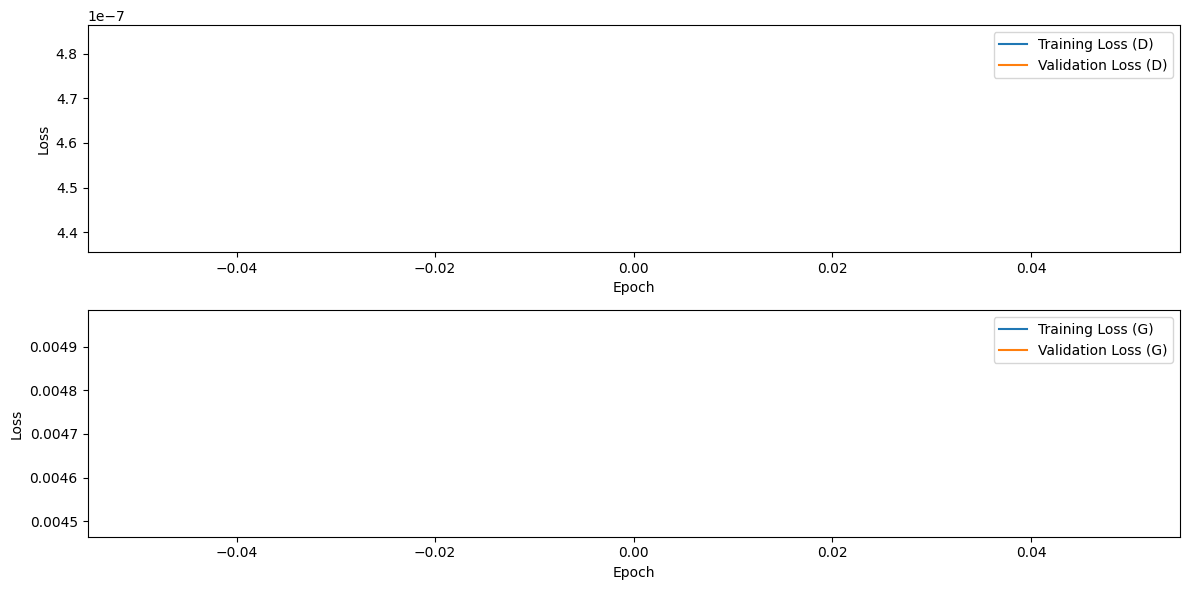

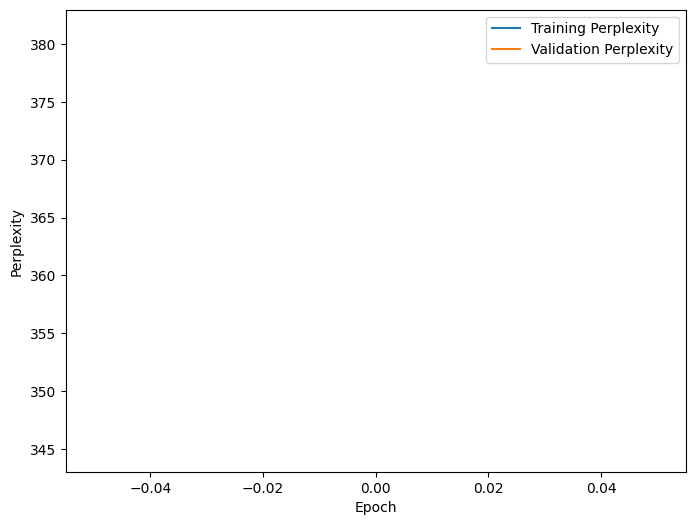

18it [00:06,  2.82it/s]


Validation DataLoader is empty.


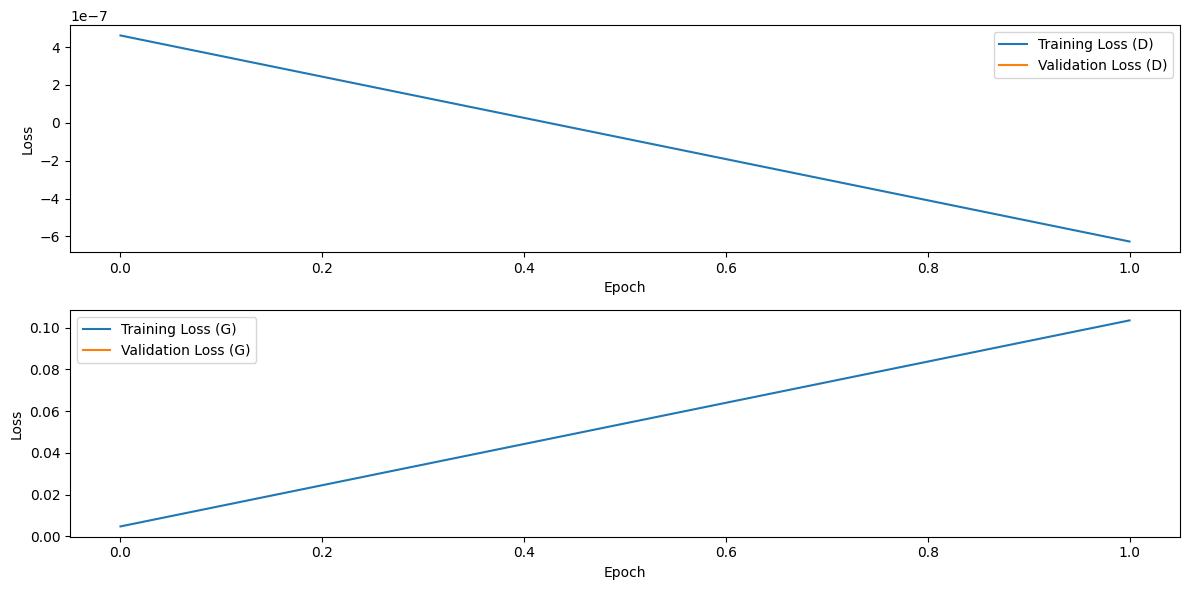

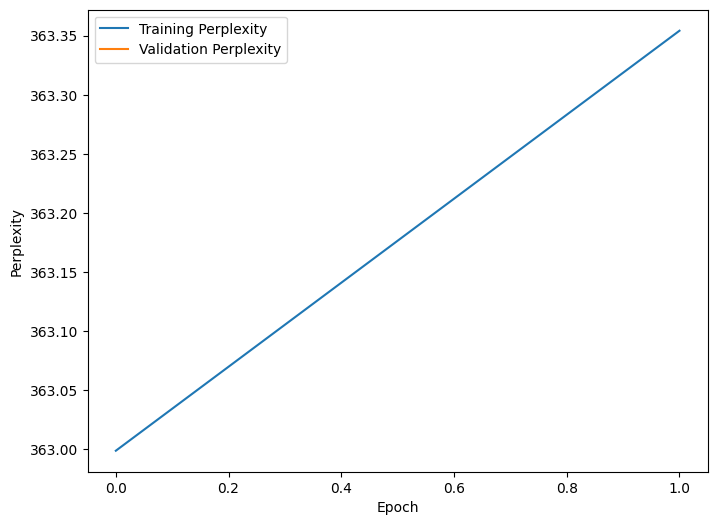

18it [00:06,  2.78it/s]


Validation DataLoader is empty.


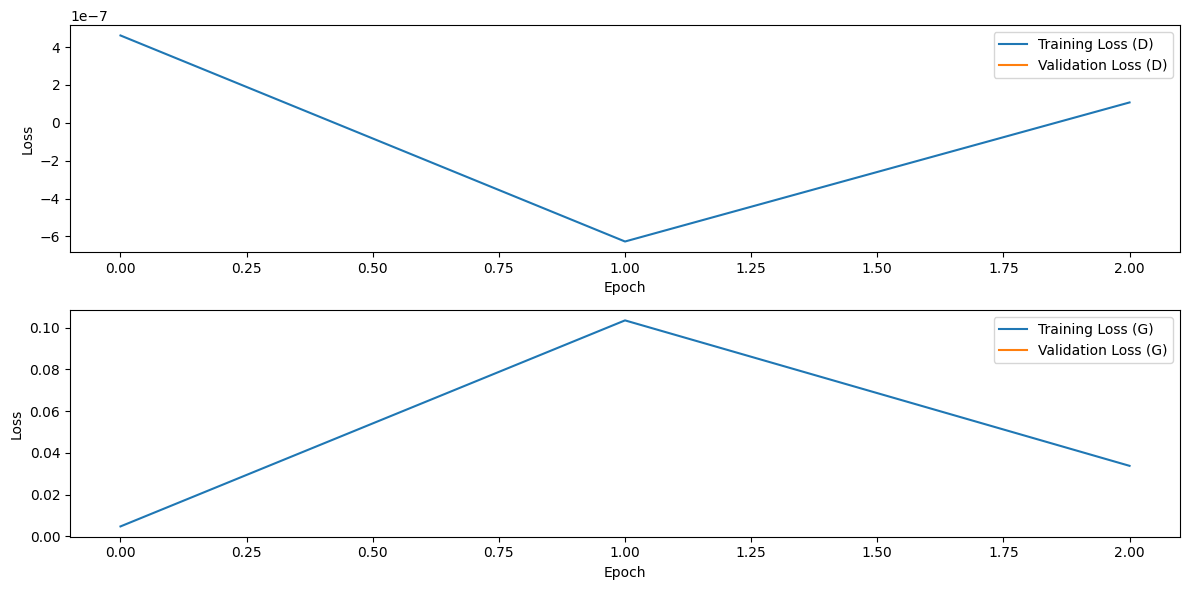

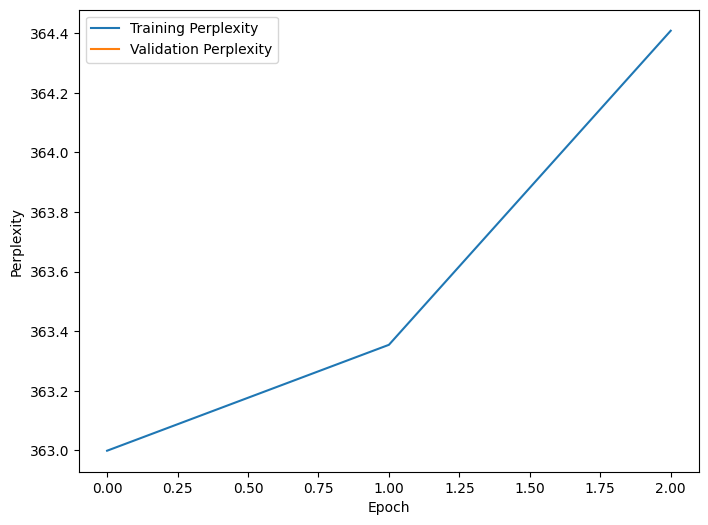

18it [00:06,  2.92it/s]


Validation DataLoader is empty.


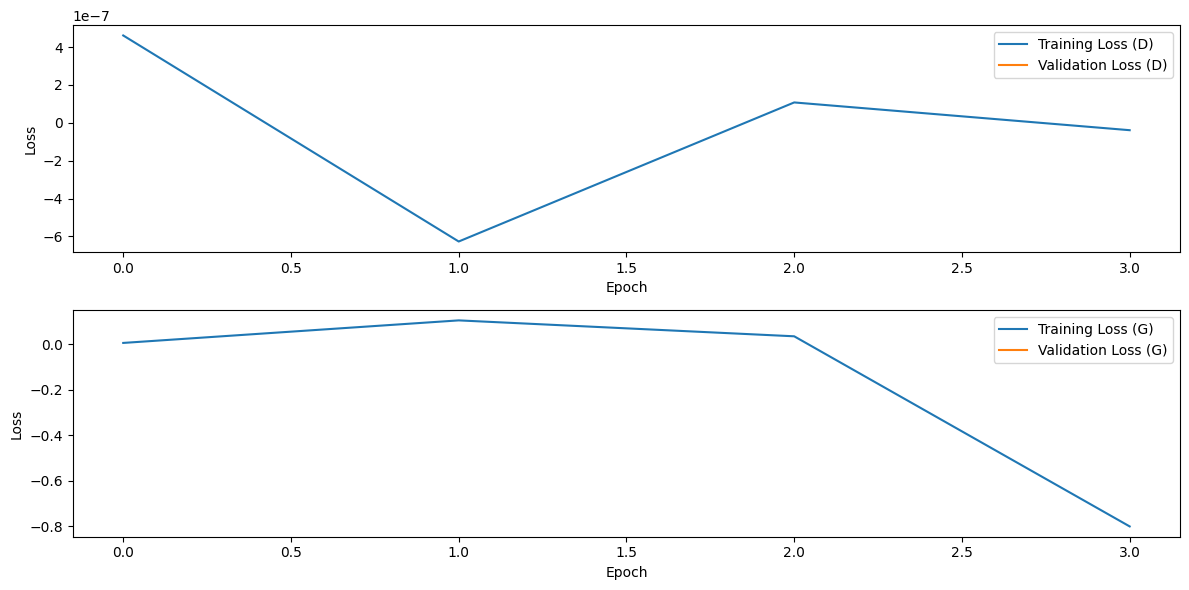

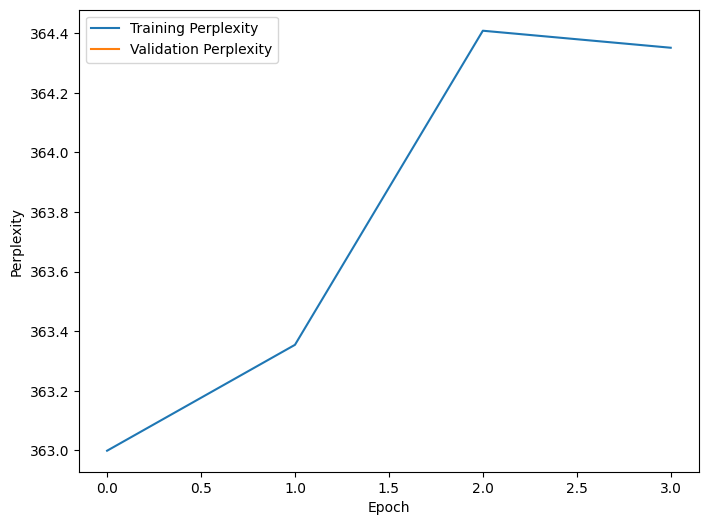

18it [00:06,  2.83it/s]


Validation DataLoader is empty.


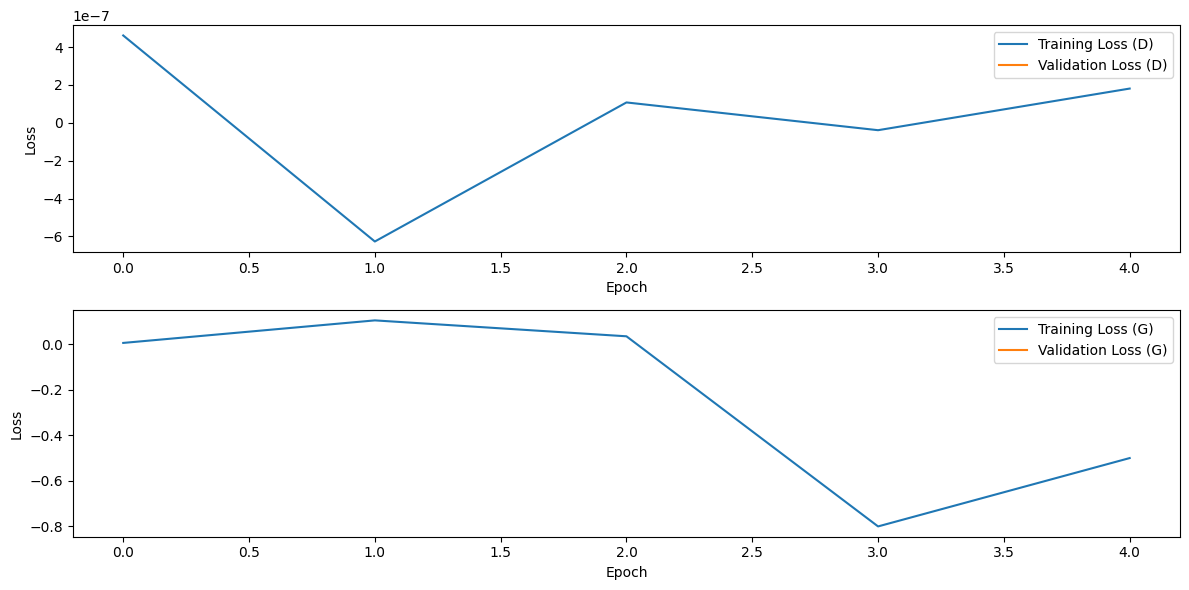

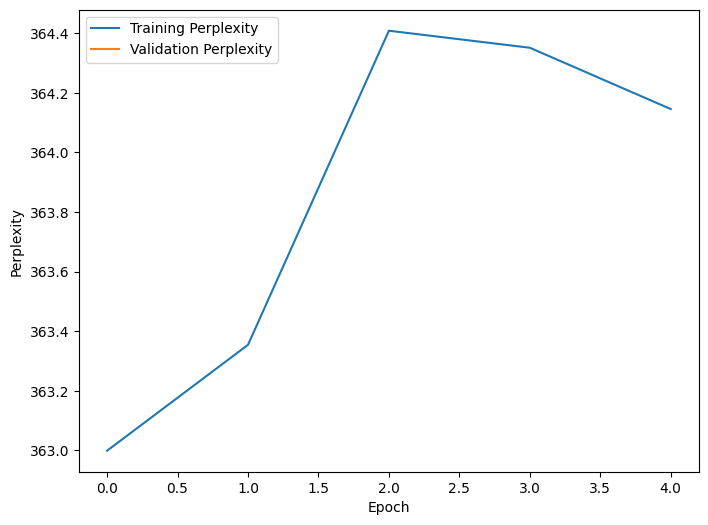

18it [00:06,  2.93it/s]


Validation DataLoader is empty.


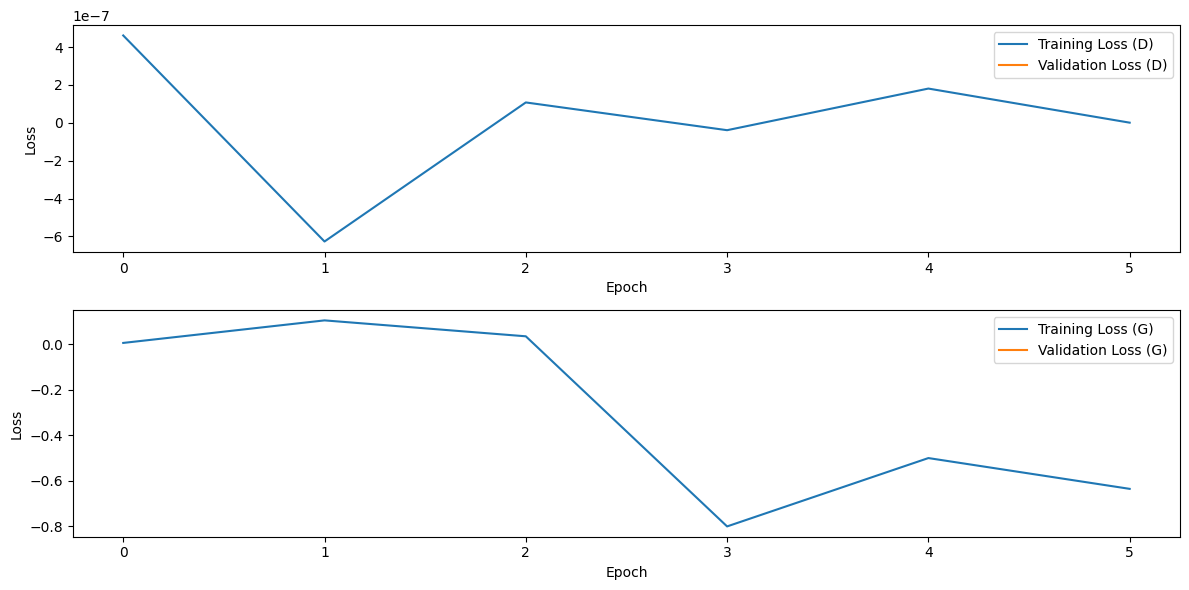

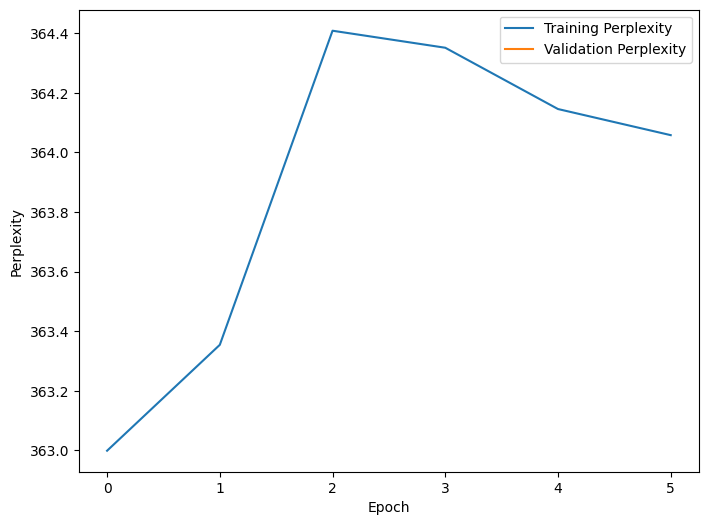

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(gen, disc, epochs, trn_dl, val_dl, optimizerD, optimizerG, crit=None, first=True):
    gen_iterations = 0
    train_losses_D = []
    train_losses_G = []
    valid_losses_D = []
    valid_losses_G = []
    train_ppl = []
    valid_ppl = []

    for epoch in range(epochs):
        gen.train(); disc.train()
        n = len(trn_dl)
        train_loss_D_epoch = 0
        train_loss_G_epoch = 0
        train_ppl_epoch = 0

        with tqdm(total=n) as pbar:
            for i, ds in enumerate(trn_dl):
                x, y = ds
                bs, sl = x.size()
                disc.eval(); gen.train()
                fake, _, _ = gen(x)
                gen.zero_grad()
                fake_sample = seq_gumbel_softmax(fake)
                with torch.no_grad():
                    gen_loss = reward = disc(fake_sample)
                    if crit: gen_loss = crit(fake, fake_sample, reward.squeeze(1))
                    gen_loss = gen_loss.mean()
                gen_loss.requires_grad_(True)
                gen_loss.backward()
                optimizerG.step()
                gen_iterations += 1
                d_iters = 3
                for j in range(d_iters):
                    gen.eval(); disc.train()
                    with torch.no_grad():
                        fake, _, _ = gen(x)
                        fake_sample = seq_gumbel_softmax(fake)
                    disc.zero_grad()
                    fake_loss = disc(fake_sample)
                    real_loss = disc(y.view(bs, sl))
                    disc_loss = (fake_loss - real_loss).mean(0)
                    disc_loss.backward()
                    optimizerD.step()

                    train_loss_D_epoch += disc_loss.data.item()
                    train_loss_G_epoch += gen_loss.data.item()
                    train_ppl_epoch += torch.exp(lm_loss(fake, y)).item()

                    pbar.update()

        train_losses_D.append(train_loss_D_epoch / n)
        train_losses_G.append(train_loss_G_epoch / n)
        train_ppl.append(train_ppl_epoch / n)

        disc.eval(); gen.eval()
        valid_loss_D_epoch = 0
        valid_loss_G_epoch = 0
        valid_ppl_epoch = 0

        if len(val_dl) > 0:
            with tqdm(total=len(val_dl)) as pbar:
                for i, ds in enumerate(val_dl):
                    with torch.no_grad():
                        x, y = ds
                        bs, sl = x.size()
                        fake, _, _ = gen(x)
                        fake_sample = seq_gumbel_softmax(fake)
                        gen_loss = reward = disc(fake_sample)
                        if crit: gen_loss = crit(fake, fake_sample, reward.squeeze(1))
                        gen_loss = gen_loss.mean()
                        fake_sample = seq_gumbel_softmax(fake)
                        fake_loss = disc(fake_sample)
                        real_loss = disc(y.view(bs, sl))
                        disc_loss = (fake_loss - real_loss).mean(0)

                        valid_loss_D_epoch += disc_loss.data.item()
                        valid_loss_G_epoch += gen_loss.data.item()
                        valid_ppl_epoch += torch.exp(lm_loss(fake, y)).item()

                    pbar.update()

            valid_losses_D.append(valid_loss_D_epoch / len(val_dl))
            valid_losses_G.append(valid_loss_G_epoch / len(val_dl))
            valid_ppl.append(valid_ppl_epoch / len(val_dl))
        else:
            print("Validation DataLoader is empty.")

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(train_losses_D, label='Training Loss (D)')
        plt.plot(valid_losses_D, label='Validation Loss (D)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(train_losses_G, label='Training Loss (G)')
        plt.plot(valid_losses_G, label='Validation Loss (G)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.plot(train_ppl, label='Training Perplexity')
        plt.plot(valid_ppl, label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.legend()
        plt.show()

    return train_losses_D, train_losses_G, valid_losses_D, valid_losses_G, train_ppl, valid_ppl

# Call the train function and store the returned values
train_losses_D, train_losses_G, valid_losses_D, valid_losses_G, train_ppl, valid_ppl = train(generator, disc, 6, dls.train, dls.valid, optimizerD, optimizerG, first=False)